# Exploratory implementation of PARAFAC II on Covid-19 data 

1. 127 samples, 149 metab pathways, 386 prot pathways

2. Decompose at rank=2,3,7,10,20, using init='svd (default is 'random') to investigate factor matrices

3. Order of pathways do not matter (identical decomposition results between original pathway orders and permuted pathway orders)

4. Note the consistency in omics level score signs across the range of ranks (the proportionality thing mentioned in the algorithm paper?)

5. http://tensorly.org/stable/auto_examples/decomposition/plot_parafac2.html to locate corresponding factor matrices, and see below a quick guideline

In [2]:
# cp_tensors = parafac2([tensor_slices], rank)

# weights, cp_factors, projections = cp_tensors

# len(cp_factors) = 3
# omics_factor_matrix = cp_factors[0] # shape = (num_omics_layer * rank)
# "blueprint"_of_pathway_matrix = cp_factors[1] # shape = (rank * rank)
# c.f. Bi = PiB where B is an rank * rank matrix and Pi is an I * rank projection matrix
# sample_factor_matrix = cp_factors[1] # shape = (num_samples * rank)

# len(projection) = num_omics_layer
# metab_pathway_mat = projections[0] # shape = (num_metab_pathways * rank)
# prot_pathway_mat = projections[1] # shape = (num_prot_pathways * rank)

In [73]:
import pickle
import tensorly as tl
import numpy as np
import pandas as pd
import tlviz
from sklearn.preprocessing import scale
from tensorly.decomposition import parafac2
from tlviz.utils import normalise
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import numpy.linalg as la
import sspa
import scipy.stats as stats
from pathway_feature_selection import bootstrap_feature_select_pr2, feature_select_bs_ci, significant_pathways, harmonic_pvalue,combined_pseudoz, significant_pseudoz, plot_zscore_distribution

#### Prepare tensors

In [4]:
with open('metab_kpca.pkl','rb') as f:
    metab_kpca = pickle.load(f)

with open('prot_kpca.pkl','rb') as f:
    prot_kpca = pickle.load(f)

with open('metadata_binary.pkl','rb') as f:
    metadata_binary = pickle.load(f)

with open('who_row_colors.pkl','rb') as f:
    who_row_colors = pickle.load(f)

with open('covid_processed_sample_data.pkl','rb') as f:
    processed_sample_data = pickle.load(f)

with open('common_pathways.pkl','rb') as f:
    common_pathways = pickle.load(f)

- Preprocessing

In [5]:
mat_to_be_processed = pd.concat([metab_kpca,prot_kpca],axis=1)

mat_centered = mat_to_be_processed - mat_to_be_processed.mean()

mat_cen_bro = scale(mat_centered,axis=1,with_mean=False)

metab_kpca_processed = mat_cen_bro[:,:metab_kpca.shape[1]]
prot_kpca_processed = mat_cen_bro[:,metab_kpca.shape[1]:]

In [6]:
metab_kpca_processed.shape

(127, 149)

In [7]:
prot_kpca_processed.shape

(127, 386)

In [8]:
metab_kpca_PRF2 = metab_kpca_processed.T

In [9]:
prot_kpca_PRF2 = prot_kpca_processed.T

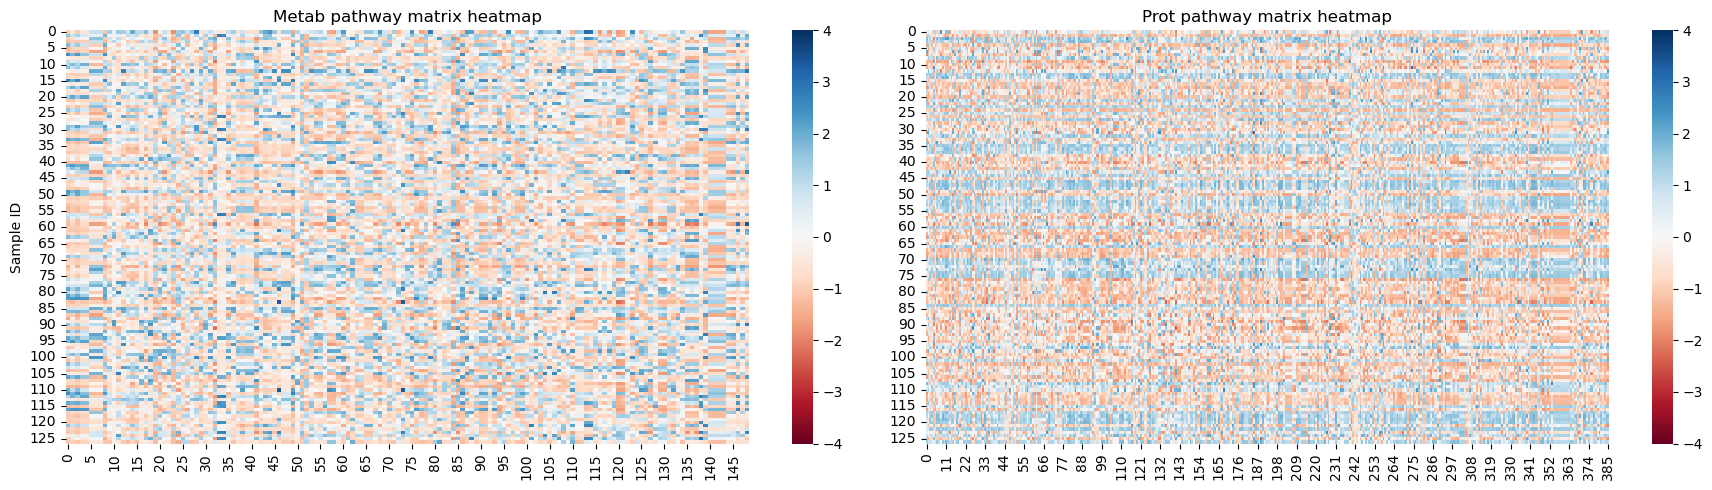

In [10]:
# Visualising the two omics pathway matrices with heatmap
plt.figure(figsize=(18,5))

plt.subplot(1,2,1)
sns.heatmap(metab_kpca_processed, cmap='RdBu',vmin=-4,vmax=4)
plt.title('Metab pathway matrix heatmap')
plt.ylabel('Sample ID')

plt.subplot(1,2,2)
sns.heatmap(prot_kpca_processed, cmap='RdBu',vmin=-4,vmax=4)
plt.title('Prot pathway matrix heatmap')


plt.tight_layout()
plt.show()

In [11]:
metab_kpca_PRF2.shape

(149, 127)

In [12]:
prot_kpca_PRF2.shape

(386, 127)

### Performance metrics
- fit (= 1- relative sum of squared error)

In [105]:
def cal_rel_sse_slice(data, est_tensor, slice_index):
    """Calculate the rev metric for given data."""
    sum_squared = np.sum(data ** 2)
    sse = np.sum((data - est_tensor[slice_index]) ** 2)
    return (1 - sse / sum_squared) 

rel_metab_dict = {}
rel_prot_dict = {}

for rank in range(1, 11):

    parafac2_decomp = parafac2([metab_kpca_PRF2, prot_kpca_PRF2], init='svd', rank=rank)
    est_tensor = tl.parafac2_tensor.parafac2_to_slices(parafac2_decomp)

    rel_metab_dict[rank] = cal_rel_sse_slice(metab_kpca_PRF2, est_tensor, 0)
    rel_prot_dict[rank] = cal_rel_sse_slice(prot_kpca_PRF2, est_tensor, 1)

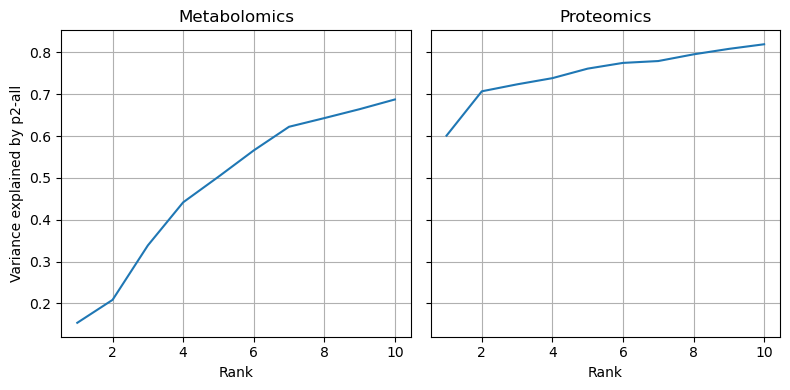

dict_values([0.1535350367287589, 0.20838852882656833, 0.3386310274005947, 0.44164487654327356, 0.502819767462396, 0.565751279136836, 0.6223436459511205, 0.643083393952741, 0.6644433741302271, 0.6876774515544875]) dict_values([0.6010724001079688, 0.7071807355736013, 0.723824279990281, 0.7386402828488056, 0.7614028910845443, 0.7751110848727198, 0.7795413813566521, 0.7955784188893757, 0.8086355574967595, 0.8196933182004984])


In [107]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
sns.lineplot(x=rel_metab_dict.keys(),y=rel_metab_dict.values(),ax=ax1)
sns.lineplot(x=rel_prot_dict.keys(),y=rel_prot_dict.values(),ax=ax2)
ax1.set_title('Metabolomics')
ax1.set_xlabel('Rank')
ax1.set_ylabel('Variance explained by p2-all')
ax2.set_title('Proteomics')
ax2.set_xlabel('Rank')
ax1.grid(True)
ax2.grid(True)
plt.tight_layout()

plt.show()
print(rel_metab_dict.values(),rel_prot_dict.values())

- Total error

In [15]:
tol_fit_dict = {}

metab_sum_squared = np.sum(metab_kpca_PRF2 ** 2)
prot_sum_squared = np.sum(prot_kpca_PRF2 ** 2)
sum_squared = metab_sum_squared + prot_sum_squared

for rank in range(1,21):
    parafac2_decomp = parafac2([metab_kpca_PRF2, prot_kpca_PRF2], init='svd', rank=rank)
    est_tensor = tl.parafac2_tensor.parafac2_to_slices(parafac2_decomp)
    sse_metab = np.sum((metab_kpca_PRF2 - est_tensor[0]) ** 2)
    sse_prot = np.sum((prot_kpca_PRF2 - est_tensor[1]) ** 2)
    sse = sse_metab + sse_prot
    tol_fit = (1 - sse / sum_squared) 
    tol_fit_dict[rank] = tol_fit

In [101]:
with open('p2_all_r2x_dict.pkl', 'wb') as f:
    pickle.dump(tol_fit_dict, f)

/var/folders/7h/31w4d6n52ds2j9y7fxh5ngjc0000gn/T/ipykernel_23046/2020883996.py:7: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



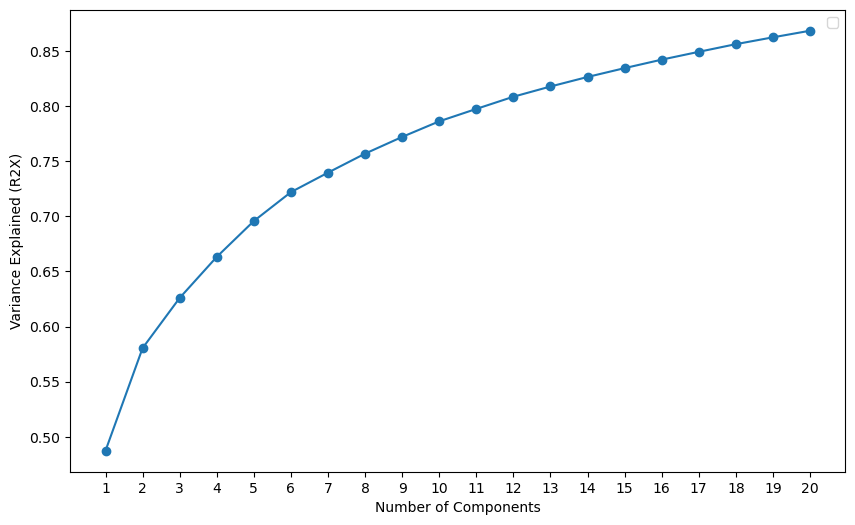

In [99]:
plt.figure(figsize=(10, 6))

plt.plot(tol_fit_dict.keys(), tol_fit_dict.values(),  marker='o')
plt.xticks(range(1,21))
plt.xlabel('Number of Components')
plt.ylabel("Variance Explained (R2X)")
plt.legend()


plt.show()

### Decompose at rank = 2

In [96]:
from tlviz.utils import normalise


def degeneracy_score_p2(p2_slices, max_rank):

    ds_dict = {}
    for rank in range(1,max_rank+1):
        cp_tensors = parafac2(p2_slices, rank,init='svd')
        weights, cp_factors, projections = cp_tensors
        # note that pathway factor matrices are ignored as constraints are put on them 
        factors = [cp_factors[1],cp_factors[0]]

        rank = factors[0].shape[1]
        tucker_congruence_scores = np.ones(shape=(rank, rank))
        if rank == 1:
            ds = 1
        else:
            for factor in factors:
                tucker_congruence_scores *= normalise(factor).T @ normalise(factor)

        # update the diagonal to zero to skip it in the max search
            np.fill_diagonal(tucker_congruence_scores,0)

            ds = abs(np.asarray(tucker_congruence_scores)).max()

        ds_dict[rank] = ds
    ds_df = pd.DataFrame.from_dict(ds_dict,orient='index')
    return ds_df


In [97]:
ds_df = degeneracy_score_p2([metab_kpca_PRF2,prot_kpca_PRF2],10)

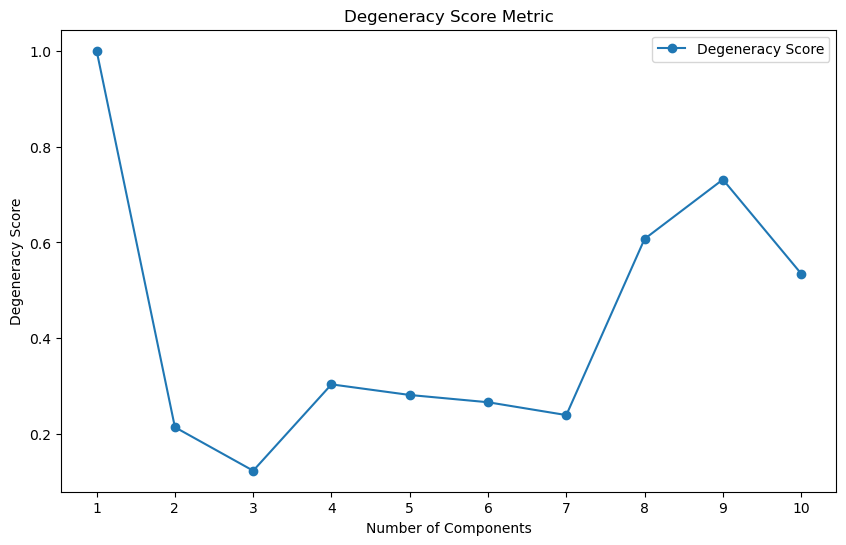

In [98]:
plt.figure(figsize=(10, 6))

plt.plot(ds_df.index, ds_df.iloc[:,0], label='Degeneracy Score', marker='o')
plt.xticks(ds_df.index)
# Adding title and labels
plt.title('Degeneracy Score Metric')
plt.xlabel('Number of Components')
plt.ylabel('Degeneracy Score')
plt.legend()


plt.show()

In [17]:
parafac2_tensor_r2 = parafac2([metab_kpca_PRF2,prot_kpca_PRF2],init='svd',rank=2)
weights_r2, factors_r2, projections_r2 = parafac2_tensor_r2
omics_mat_r2,Sk_r2, sample_mat_r2 = factors_r2

##### Heatmap to visualise sample, pathway and omics level factor matrices

Text(0.5, 1.0, 'p2-all Omics level factor matrix heatmap')

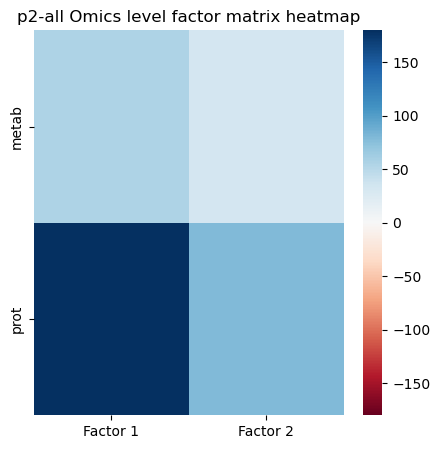

In [152]:
plt.figure(figsize=(5,5))
df_omics_r2 = pd.DataFrame(omics_mat_r2,index=['metab','prot'],columns=['Factor 1','Factor 2'])
sns.heatmap(df_omics_r2, cmap='RdBu',vmin=-180,vmax=180)
plt.title('p2-all Omics level factor matrix heatmap')

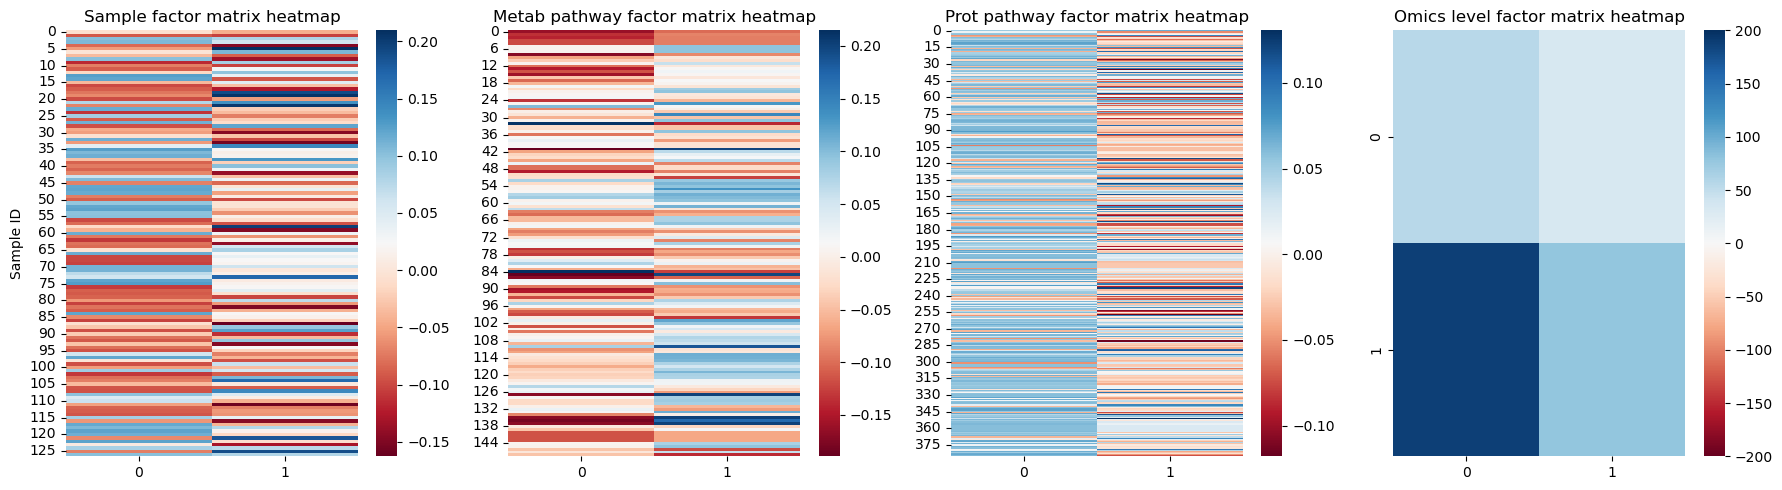

In [20]:
plt.figure(figsize=(18,5))

plt.subplot(1,4,1)
sns.heatmap(sample_mat_r2, cmap='RdBu')
plt.title('Sample factor matrix heatmap')
plt.ylabel('Sample ID')

plt.subplot(1,4,2)
sns.heatmap(projections_r2[0], cmap='RdBu')
plt.title('Metab pathway factor matrix heatmap')

plt.subplot(1,4,3)
sns.heatmap(projections_r2[1], cmap='RdBu')
plt.title('Prot pathway factor matrix heatmap')

plt.subplot(1,4,4)
sns.heatmap(omics_mat_r2, cmap='RdBu',vmin=-200,vmax=200)
plt.title('Omics level factor matrix heatmap')

plt.tight_layout()
plt.show()

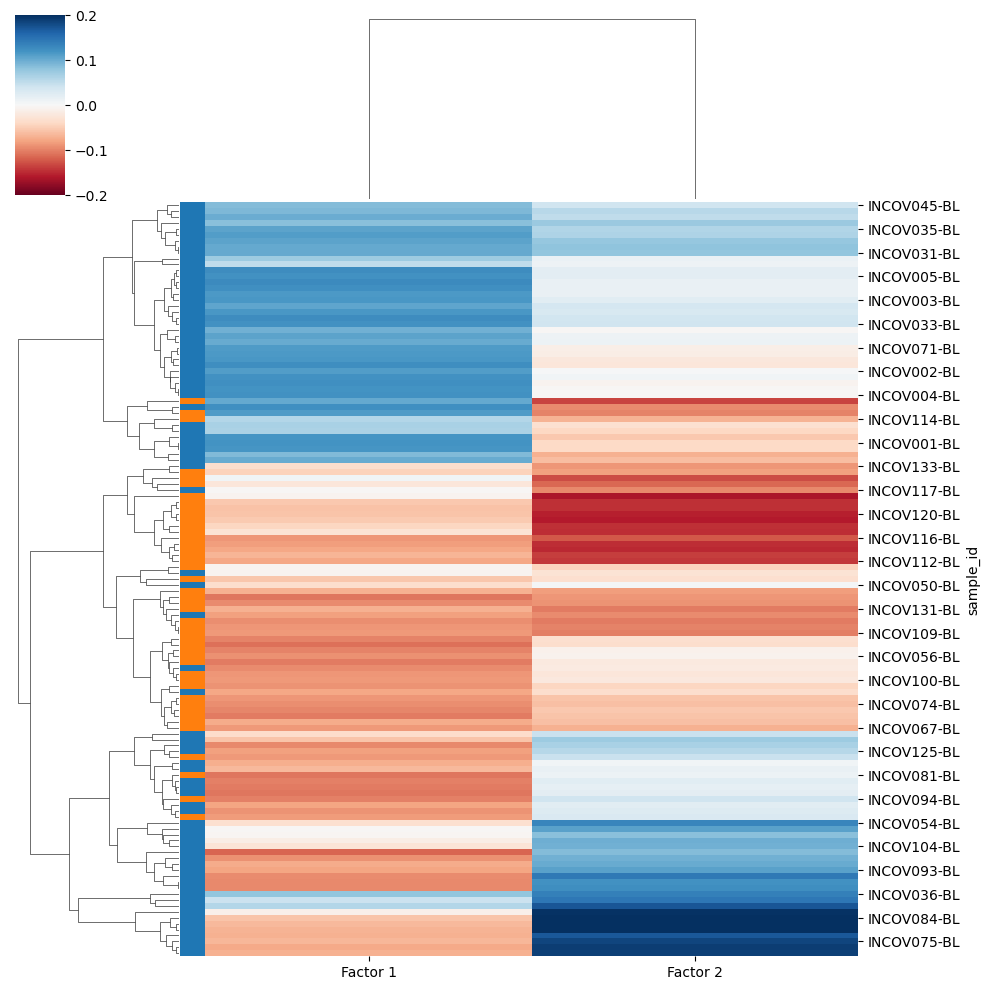

In [205]:
df_metab_samp_r2=pd.DataFrame(sample_mat_r2,index=metab_kpca.index, columns=['Factor 1','Factor 2'])
sns.clustermap(df_metab_samp_r2,cmap='RdBu',vmax=0.2,vmin=-0.2, row_colors=["tab:orange" if i == 0 else "tab:blue" for i in metadata_binary]
               )

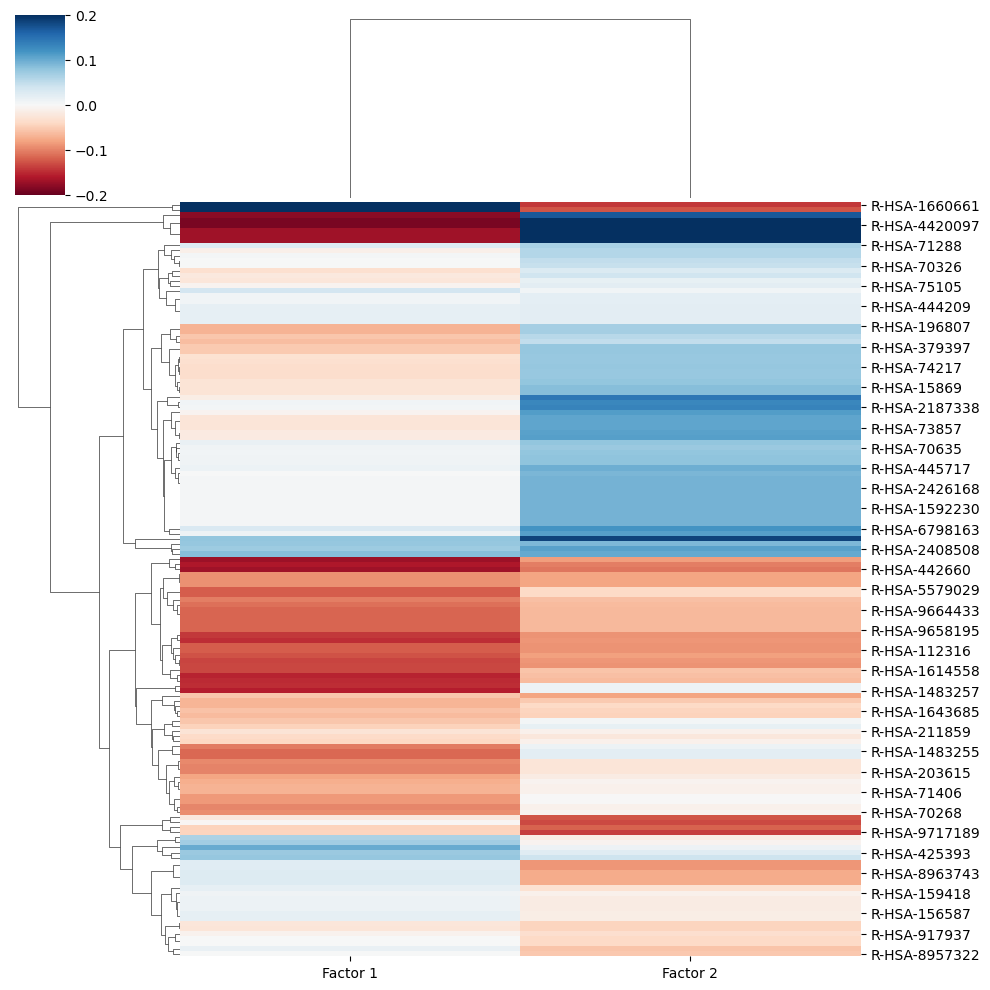

In [157]:
df_metab_path_r2=pd.DataFrame(projections_r2[0],index=metab_kpca.columns, columns=['Factor 1','Factor 2'])
sns.clustermap(df_metab_path_r2,cmap='RdBu',vmax=0.2,vmin=-0.2)

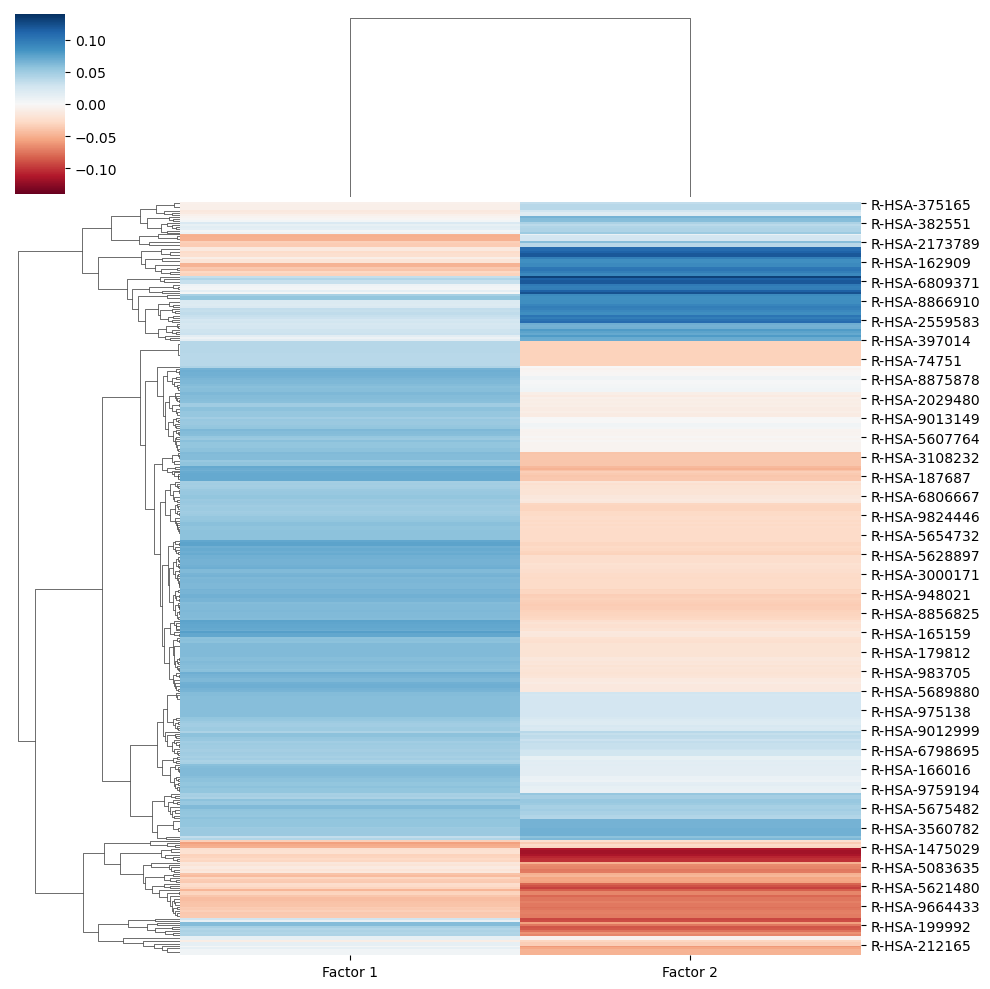

In [166]:
df_prot_path_r2=pd.DataFrame(projections_r2[1],index=prot_kpca.columns, columns=['Factor 1','Factor 2'])
sns.clustermap(df_prot_path_r2,cmap='RdBu',vmax=0.14,vmin=-0.14)

- Reconstruct the two tensor slices using the rank-2 decomposed factor matrices
- Proteomics: good recovery, probabily due to larger pathway number (or more structured pattern in prot vs more randomised pattern in metab?)

In [21]:
recon_slices_r2 = tl.parafac2_tensor.parafac2_to_slices(parafac2_tensor_r2)

- Visualy compare original vs reconstructed omics pathway matrices with heatmap 

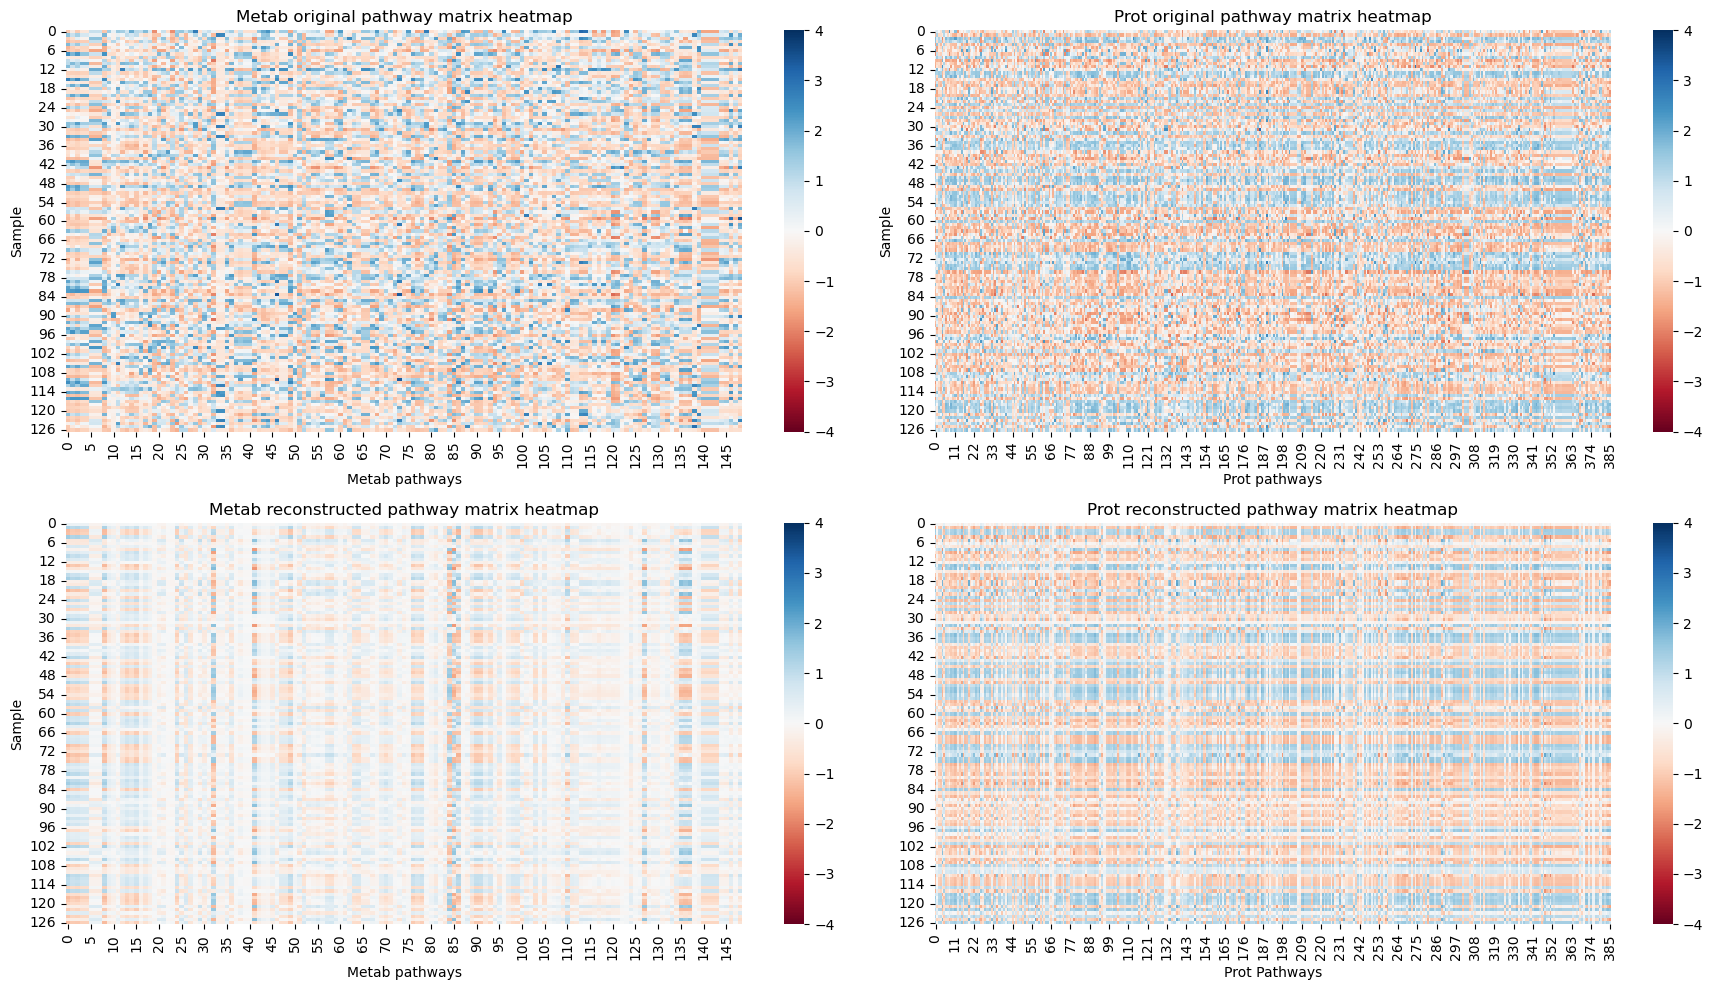

In [206]:
recon_slices_r2 = tl.parafac2_tensor.parafac2_to_slices(parafac2_tensor_r2)
plt.figure(figsize=(18,10))

plt.subplot(2,2,1)
sns.heatmap(metab_kpca_processed, cmap='RdBu',vmin=-4,vmax=4)
plt.title('Metab original pathway matrix heatmap')
plt.ylabel('Sample')
plt.xlabel('Metab pathways')

plt.subplot(2,2,3)
sns.heatmap(recon_slices_r2[0].T, cmap='RdBu',vmin=-4,vmax=4)
plt.title('Metab reconstructed pathway matrix heatmap')
plt.ylabel('Sample')
plt.xlabel('Metab pathways')

plt.subplot(2,2,2)
sns.heatmap(prot_kpca_processed, cmap='RdBu',vmin=-4,vmax=4)
plt.title('Prot original pathway matrix heatmap')
plt.ylabel('Sample')
plt.xlabel('Prot pathways')

plt.subplot(2,2,4)
sns.heatmap(recon_slices_r2[1].T, cmap='RdBu',vmin=-4,vmax=4)
plt.title('Prot reconstructed pathway matrix heatmap')
plt.xlabel('Prot Pathways')


plt.tight_layout()
plt.show()

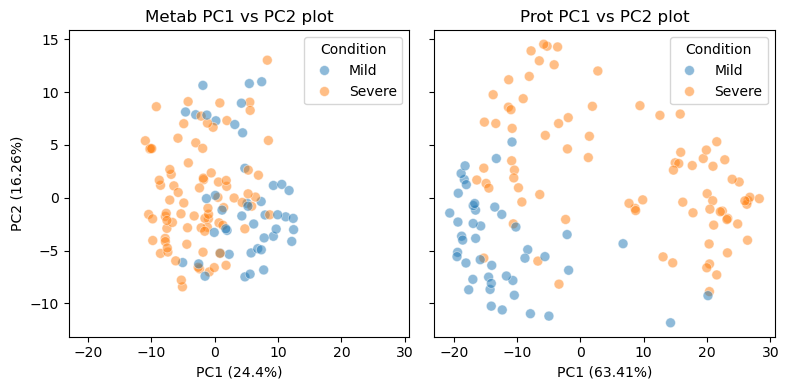

In [104]:
# Proteomics: good recovery, probabily due to a large variance_explained by PC1 (63%)?

metab_kpca_scores_norm = pd.DataFrame(StandardScaler().fit_transform(metab_kpca), index=metab_kpca.index,columns=metab_kpca.columns)

pca_metab = PCA(n_components=2)
pca_metab_res = pca_metab.fit_transform(metab_kpca_scores_norm)

pca_metab.explained_variance_ratio_


prot_kpca_scores_norm = pd.DataFrame(StandardScaler().fit_transform(prot_kpca), index=prot_kpca.index,columns=prot_kpca.columns)

pca_prot = PCA(n_components=2)
pca_prot_res = pca_prot.fit_transform(prot_kpca_scores_norm)

# determine the variance explained by the first 2 components
pca_prot.explained_variance_ratio_

plt.style.use("default")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
sns.scatterplot(x=pca_metab_res[:, 0], y=pca_metab_res[:, 1], hue=metadata_binary, ax=ax1, s=50, alpha=0.5)
sns.scatterplot(x=pca_prot_res[:, 0], y=pca_prot_res[:, 1], hue=metadata_binary, ax=ax2, s=50, alpha=0.5)

# Set axis labels
ax1.set_xlabel('PC1 (' + str(round(pca_metab.explained_variance_ratio_[0]*100,2)) + '%)')
ax1.set_ylabel('PC2 (' + str(round(pca_metab.explained_variance_ratio_[1]*100,2)) + '%)')
ax1.set_title('Metab PC1 vs PC2 plot')

ax2.set_xlabel('PC1 (' + str(round(pca_prot.explained_variance_ratio_[0]*100,2)) + '%)')
ax2.set_ylabel('PC2 (' + str(round(pca_prot.explained_variance_ratio_[1]*100,2)) + '%)')
ax2.set_title('Prot PC1 vs PC2 plot')

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles=handles, labels=['Mild', 'Severe'], title='Condition', loc='upper right')  # Customize legend for ax1
ax2.legend(title='Condition', loc='upper right', handles=handles, labels=['Mild', 'Severe'])  # Same legend for ax2

plt.tight_layout()

plt.show()


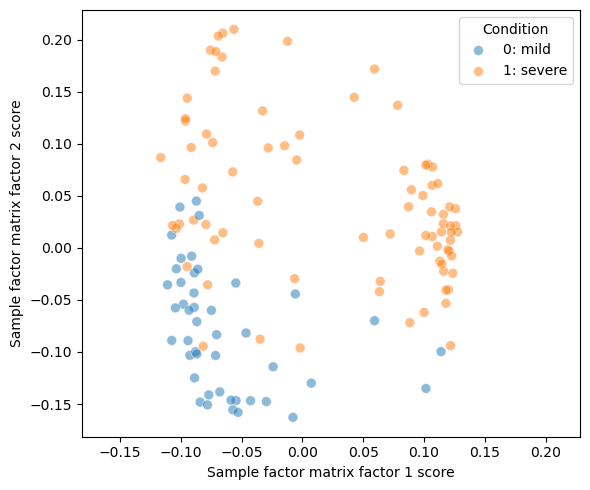

In [110]:
plt.figure(figsize=(6,5))
g = sns.scatterplot(x=sample_mat_r2[:, 0], y=sample_mat_r2[:, 1], hue=metadata_binary, s=50, alpha=0.5)

# Set axis labels
g.set_xlabel('Sample factor matrix factor 1 score')
g.set_ylabel('Sample factor matrix factor 2 score')

# Get the limits of x and y axes
x_limits = g.get_xlim()
y_limits = g.get_ylim()

# Calculate the new limits to set equal for both axes
lim = min(x_limits[0], y_limits[0]), max(x_limits[1], y_limits[1])
handles = g.get_legend_handles_labels()[0]
labels = ['0: mild', '1: severe']
g.legend(handles=handles, labels=labels, title='Condition')

# Set the same limits for both axes
g.set_xlim(lim)
g.set_ylim(lim)

plt.tight_layout()
plt.show()

In [25]:
df_sample_r2 = pd.DataFrame(sample_mat_r2,index=metab_kpca.index, columns = [f"Factor {i}" for i in range(1,3)])

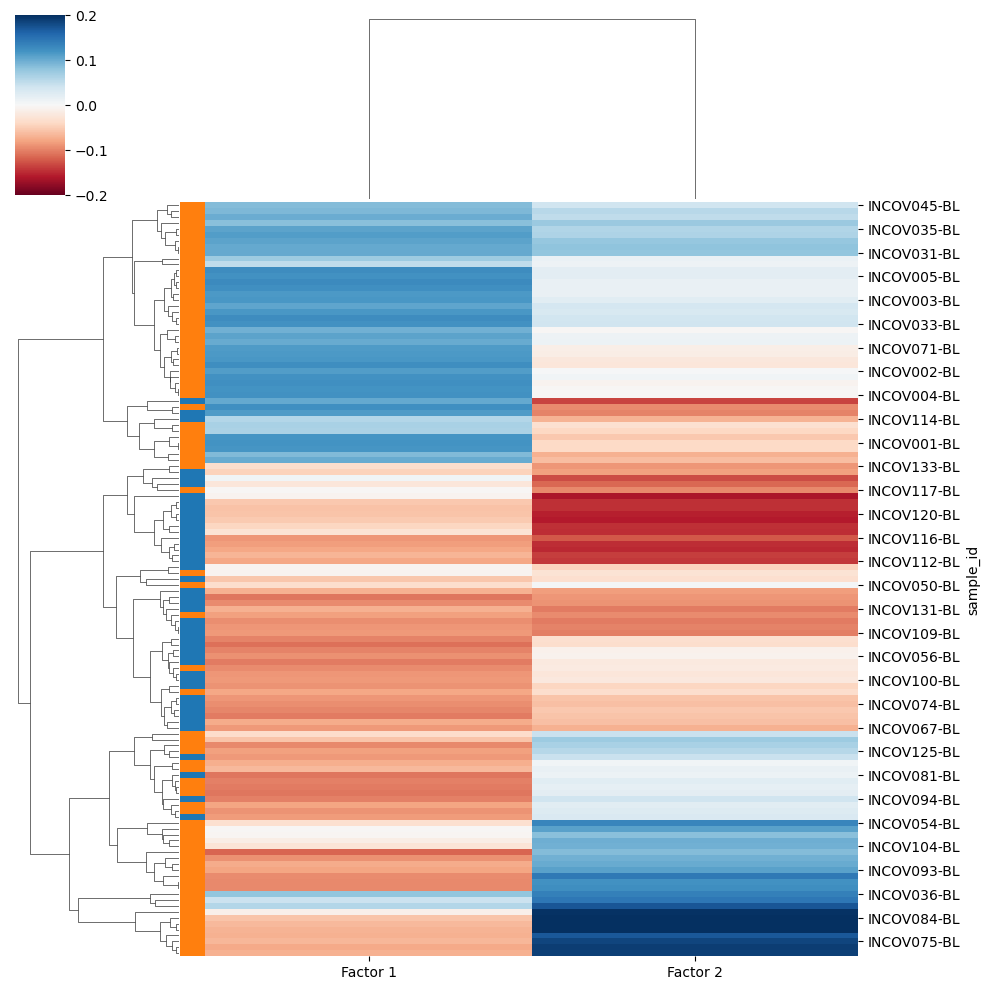

In [26]:
sns.clustermap(df_sample_r2, 
               cmap='RdBu',
               row_colors=["tab:blue" if i == 0 else "tab:orange" for i in metadata_binary],
               
               vmin=-0.2,vmax=0.2)

In [27]:
with open('p2all_df_sample_r2.pkl', 'wb') as f:
    pickle.dump(df_sample_r2, f)

#### log reg
- Performing SMOTE to address imbalanced classes then fitting sample factor 1 and factor 2 scores separately to a linear regressor and evaluate with metrics (accuracy and confusion matrix)

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

In [29]:
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score

X = df_sample_r2 
y = metadata_binary 

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_list = []
roc_auc_list = []
f1_list = []

for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    smote = SMOTE(sampling_strategy='minority', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    logreg = LogisticRegression()
    logreg.fit(X_train_resampled, y_train_resampled)

    y_pred = logreg.predict(X_test)
    y_pred_probs = logreg.predict_proba(X_test)[:, 1]
  
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_probs)
    f1 = f1_score(y_test, y_pred)

    accuracy_list.append(accuracy)
    roc_auc_list.append(roc_auc)
    f1_list.append(f1)

average_accuracy = np.mean(accuracy_list)
average_roc_auc = np.mean(roc_auc_list)
average_f1 = np.mean(f1_list)

print(f"Average Accuracy: {average_accuracy:.2f}")
print(f"Average ROC AUC: {average_roc_auc:.2f}")
print(f"Average F1 Score: {average_f1:.2f}")


Average Accuracy: 0.87
Average ROC AUC: 0.96
Average F1 Score: 0.90


In [30]:
X_1 = df_sample_r2[['Factor 1']]
y = metadata_binary 

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_list = []
roc_auc_list = []
f1_list = []

for train_index, test_index in skf.split(X_1, y):
    X_train_1, X_test_1 = X_1.iloc[train_index], X_1.iloc[test_index]
    y_train_1, y_test_1 = y.iloc[train_index], y.iloc[test_index]

    smote = SMOTE(sampling_strategy='minority', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_1, y_train_1)

    logreg_1 = LogisticRegression()
    logreg_1.fit(X_train_resampled, y_train_resampled)

    y_pred_1 = logreg_1.predict(X_test_1)
    y_pred_1_probs = logreg_1.predict_proba(X_test_1)[:, 1]
    
    accuracy = accuracy_score(y_test_1, y_pred_1)
    roc_auc = roc_auc_score(y_test_1, y_pred_1_probs)
    f1 = f1_score(y_test_1, y_pred_1)

    accuracy_list.append(accuracy)
    roc_auc_list.append(roc_auc)
    f1_list.append(f1)
    
average_accuracy = np.mean(accuracy_list)
average_roc_auc = np.mean(roc_auc_list)
average_f1 = np.mean(f1_list)

print(f"Average Accuracy: {average_accuracy:.2f}")
print(f"Average ROC AUC: {average_roc_auc:.2f}")
print(f"Average F1 Score: {average_f1:.2f}")

Average Accuracy: 0.70
Average ROC AUC: 0.78
Average F1 Score: 0.73


In [31]:
X_2 = df_sample_r2[['Factor 2']]  # Use Factor 2 as the feature
y = metadata_binary

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

accuracy_list = []
roc_auc_list = []
f1_list = []

for train_index, test_index in skf.split(X_2, y):
    X_train_2, X_test_2 = X_2.iloc[train_index], X_2.iloc[test_index]
    y_train_2, y_test_2 = y.iloc[train_index], y.iloc[test_index]
    
    smote = SMOTE(sampling_strategy='minority', random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_2, y_train_2)

    logreg_2 = LogisticRegression()
    logreg_2.fit(X_train_resampled, y_train_resampled)

    y_pred_2 = logreg_2.predict(X_test_2)
    y_pred_2_probs = logreg_2.predict_proba(X_test_2)[:, 1]

    accuracy = accuracy_score(y_test_2, y_pred_2)
    roc_auc = roc_auc_score(y_test_2, y_pred_2_probs)
    f1 = f1_score(y_test_2, y_pred_2)

    accuracy_list.append(accuracy)
    roc_auc_list.append(roc_auc)
    f1_list.append(f1)

average_accuracy = np.mean(accuracy_list)
average_roc_auc = np.mean(roc_auc_list)
average_f1 = np.mean(f1_list)

print(f"Average Accuracy: {average_accuracy:.2f}")
print(f"Average ROC AUC: {average_roc_auc:.2f}")
print(f"Average F1 Score: {average_f1:.2f}")

Average Accuracy: 0.83
Average ROC AUC: 0.92
Average F1 Score: 0.86


In [32]:
X = df_sample_r2  
y = metadata_binary  

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# For both factors as features
f1_scores = []
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    model = LogisticRegression()
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    f1_scores.append(f1)

f1_uncorrected = np.mean(f1_scores)

# For factor 1
X_1 = df_sample_r2[['Factor 1']]
f1_scores_fac1 = []
for train_index, test_index in skf.split(X_1, y):
    X_train_1, X_test_1 = X_1.iloc[train_index], X_1.iloc[test_index]
    y_train_1, y_test_1 = y.iloc[train_index], y.iloc[test_index]
    
    model_1 = LogisticRegression()
    model_1.fit(X_train_1, y_train_1)
    
    y_pred_1 = model_1.predict(X_test_1)
    f1_fac1 = f1_score(y_test_1, y_pred_1)
    f1_scores_fac1.append(f1_fac1)

f1_fac1_uncorrected = np.mean(f1_scores_fac1)

# For factor 2
X_2 = df_sample_r2[['Factor 2']]
f1_scores_fac2 = []
for train_index, test_index in skf.split(X_2, y):
    X_train_2, X_test_2 = X_2.iloc[train_index], X_2.iloc[test_index]
    y_train_2, y_test_2 = y.iloc[train_index], y.iloc[test_index]
    
    model_2 = LogisticRegression()
    model_2.fit(X_train_2, y_train_2)
    
    y_pred_2 = model_2.predict(X_test_2)
    f1_fac2 = f1_score(y_test_2, y_pred_2)
    f1_scores_fac2.append(f1_fac2)

f1_fac2_uncorrected = np.mean(f1_scores_fac2)

print(f"F1 Score for both factors as feature: {f1_uncorrected:.2f}\n"
      f"F1 Score for factor 1: {f1_fac1_uncorrected:.2f}\n"
      f"F1 Score for factor 2: {f1_fac2_uncorrected:.2f} ")

F1 Score for both factors as feature: 0.78
F1 Score for factor 1: 0.78
F1 Score for factor 2: 0.78 


[0.6923076923076923, 0.7307692307692307, 0.8, 0.72, 0.56] [0.8562091503267973, 0.8300653594771242, 0.8333333333333334, 0.7569444444444444, 0.638888888888889] [0.7142857142857143, 0.7407407407407407, 0.8148148148148148, 0.7407407407407407, 0.6206896551724138]
[0.8076923076923077, 0.8461538461538461, 0.84, 0.8, 0.84] [0.9215686274509803, 0.9084967320261438, 0.9444444444444444, 0.9027777777777779, 0.9444444444444444] [0.8387096774193549, 0.8888888888888888, 0.8571428571428571, 0.8484848484848485, 0.8571428571428571]
[0.8846153846153846, 0.8846153846153846, 0.92, 0.88, 0.8] [0.9673202614379085, 0.9673202614379085, 0.9930555555555555, 0.9583333333333334, 0.9166666666666667] [0.9032258064516129, 0.9090909090909091, 0.9333333333333333, 0.9090909090909091, 0.8275862068965517]


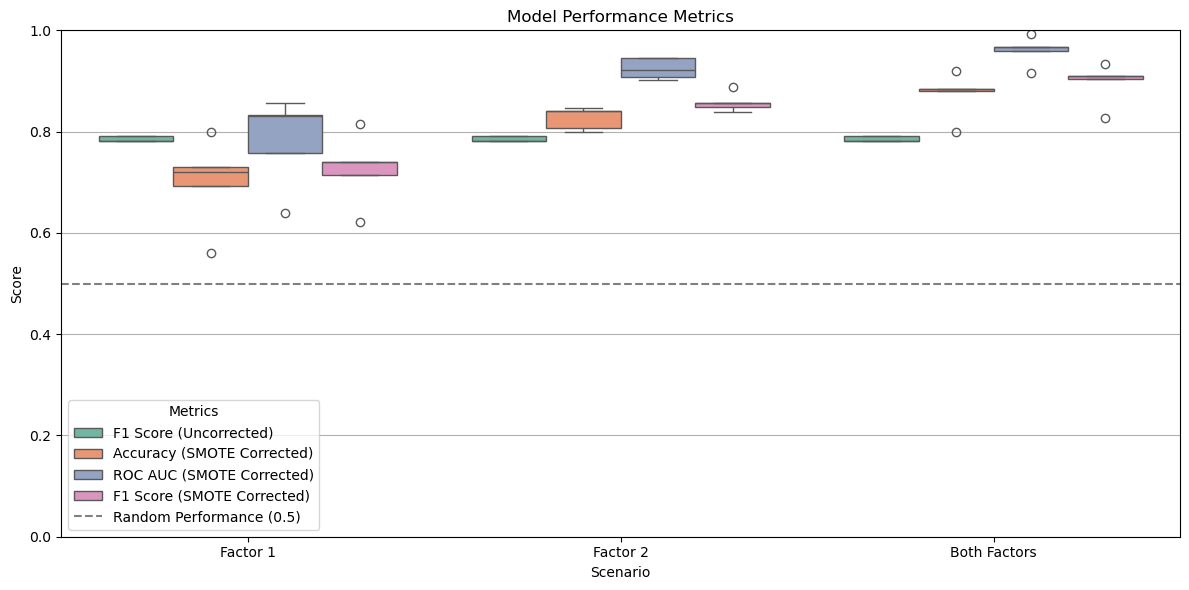

In [33]:
def compute_metrics(X, y, use_smote=False):
    accuracy_list = []
    roc_auc_list = []
    f1_list = []
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        if use_smote:
            smote = SMOTE(sampling_strategy='minority', random_state=42)
            X_train, y_train = smote.fit_resample(X_train, y_train)

        model = LogisticRegression()
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        y_pred_probs = model.predict_proba(X_test)[:, 1]

        accuracy_list.append(accuracy_score(y_test, y_pred))
        roc_auc_list.append(roc_auc_score(y_test, y_pred_probs))
        f1_list.append(f1_score(y_test, y_pred))

    return accuracy_list, roc_auc_list, f1_list

scenarios = {
    "Factor 1": df_sample_r2[['Factor 1']],
    "Factor 2": df_sample_r2[['Factor 2']],
    "Both Factors": df_sample_r2
}

metrics = {
    "Scenario": [],
    "Metric": [],
    "Score": []
}

for scenario_name, X in scenarios.items():
    y = metadata_binary
    
    f1_uncorrected = compute_metrics(X, y, use_smote=False)[2]

    for score in f1_uncorrected:
        metrics["Scenario"].append(scenario_name)
        metrics["Metric"].append("F1 Score (Uncorrected)")
        metrics["Score"].append(score)

    accuracy_smote, roc_auc_smote, f1_smote = compute_metrics(X, y, use_smote=True)
    
    print(accuracy_smote, roc_auc_smote, f1_smote)
    for score in accuracy_smote:
        metrics["Scenario"].append(scenario_name)
        metrics["Metric"].append("Accuracy (SMOTE Corrected)")
        metrics["Score"].append(score)

    for score in roc_auc_smote:
        metrics["Scenario"].append(scenario_name)
        metrics["Metric"].append("ROC AUC (SMOTE Corrected)")
        metrics["Score"].append(score)
        
    for score in f1_smote:
        metrics["Scenario"].append(scenario_name)
        metrics["Metric"].append("F1 Score (SMOTE Corrected)")
        metrics["Score"].append(score)

# Create a DataFrame for easier plotting
metrics_df = pd.DataFrame(metrics)

# Set up the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(data=metrics_df, x='Scenario', y='Score', hue='Metric', palette='Set2')
plt.title('Model Performance Metrics')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.axhline(0.5, color='gray', linestyle='--', label='Random Performance (0.5)')
plt.legend(title='Metrics')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### Investigating pathway factor matrices

In [208]:
df_metab_path_r2 = pd.DataFrame(projections_r2[0],index=metab_kpca.columns, columns = [f"Factor {i}" for i in range(1,3)])

df_prot_path_r2 = pd.DataFrame(projections_r2[1],index=prot_kpca.columns, columns = [f"Factor {i}" for i in range(1,3)])

In [209]:
with open('p2all_path_metab_r2.pkl', 'wb') as f:
    pickle.dump(df_metab_path_r2, f)

with open('p2all_path_prot_r2.pkl', 'wb') as f:
    pickle.dump(df_prot_path_r2, f)

In [35]:
# Plotly version scatter plot to identify 'outlier' pathways
import plotly.express as px

colour = ["Common pathways" if i in common_pathways else "Unique pathways" for i in df_metab_path_r2.index]

fig = px.scatter(
    df_metab_path_r2,
    x='Factor 1',
    y='Factor 2',
    color=colour,
    hover_name=df_metab_path_r2.index  
)

fig.update_layout(
    title="Scatter Plot of Metab Pathway Factor Matrix Scores 1 vs 2",
    xaxis_title="Metab Pathway Matrix Factor 1 Score",
    yaxis_title="Metab Pathway Matrix Factor 2 Score",
    showlegend=False  
)

fig.show()

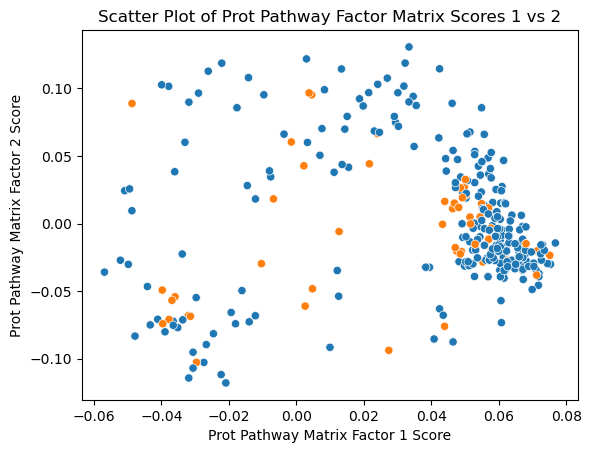

In [38]:
sns.scatterplot(x=df_prot_path_r2.iloc[:, 0], y=df_prot_path_r2.iloc[:, 1], hue=["tab:orange" if i in common_pathways else "tab:blue" for i in df_prot_path_r2.index],legend=False)

# Add a title and labels if desired
plt.title("Scatter Plot of Prot Pathway Factor Matrix Scores 1 vs 2")
plt.xlabel("Prot Pathway Matrix Factor 1 Score")
plt.ylabel("Prot Pathway Matrix Factor 2 Score")

plt.grid(False)
# Show the plot
plt.show()

In [39]:
#sns.clustermap(df_metab_path_r2, cmap='RdBu',method='ward',vmin=-0.2,vmax=0.2)

In [40]:
metab_pathways  = sspa.process_reactome(organism="Homo sapiens")

In [41]:
metab_pathway_mapping = metab_pathways.set_index(metab_pathways.index)['Pathway_name'].to_dict()
metabpath_plt_df_r2 = df_metab_path_r2[['Factor 1','Factor 2']]
metabpath_plt_df_r2['Pathway_name'] = metabpath_plt_df_r2.index.map(metab_pathway_mapping)
metabpath_plt_df_r2 = metabpath_plt_df_r2.reset_index()
metabpath_plt_df_r2.rename(columns={'index':'Pathway_ID'},inplace=True)
metabpath_plt_df_r2.sort_values(by='Factor 1', ascending=False)

Pathway_ID  Factor 1  Factor 2                            Pathway_name
84    R-HSA-428157  0.214833 -0.125642                 Sphingolipid metabolism
32   R-HSA-1660661  0.213237 -0.141706       Sphingolipid de novo biosynthesis
26    R-HSA-162582  0.101395  0.009997                     Signal Transduction
58   R-HSA-2408522  0.084880  0.102261             Selenoamino acid metabolism
110    R-HSA-71387  0.078247  0.184898             Metabolism of carbohydrates
..             ...       ...       ...                                     ...
127  R-HSA-8939211 -0.169399  0.201296                  ESR-mediated signaling
8     R-HSA-140179 -0.170601 -0.084342                 Amine Oxidase reactions
136  R-HSA-9006934 -0.180448  0.169838  Signaling by Receptor Tyrosine Kinases
41    R-HSA-194138 -0.189199  0.198883                       Signaling by VEGF
85   R-HSA-4420097 -0.189199  0.198883                    VEGFA-VEGFR2 Pathway

[149 rows x 4 columns]

In [42]:
metabpath_plt_df_r2.sort_values(by='Factor 2', ascending=False)

Pathway_ID  Factor 1  Factor 2  \
135  R-HSA-9006931 -0.169399  0.201296   
137  R-HSA-9009391 -0.169399  0.201296   
127  R-HSA-8939211 -0.169399  0.201296   
41    R-HSA-194138 -0.189199  0.198883   
85   R-HSA-4420097 -0.189199  0.198883   
..             ...       ...       ...   
84    R-HSA-428157  0.214833 -0.125642   
51    R-HSA-211897 -0.021721 -0.125801   
100   R-HSA-597592 -0.004646 -0.132259   
148  R-HSA-9717189 -0.044062 -0.138502   
32   R-HSA-1660661  0.213237 -0.141706   

                                     Pathway_name  
135                Signaling by Nuclear Receptors  
137              Extra-nuclear estrogen signaling  
127                        ESR-mediated signaling  
41                              Signaling by VEGF  
85                           VEGFA-VEGFR2 Pathway  
..                                            ...  
84                        Sphingolipid metabolism  
51   Cytochrome P450 - arranged by substrate type  
100       Post-translational protein modification  
148                   Sensory perception of taste  
32              Sphingolipid de novo biosynthesis  

[149 rows x 4 columns]

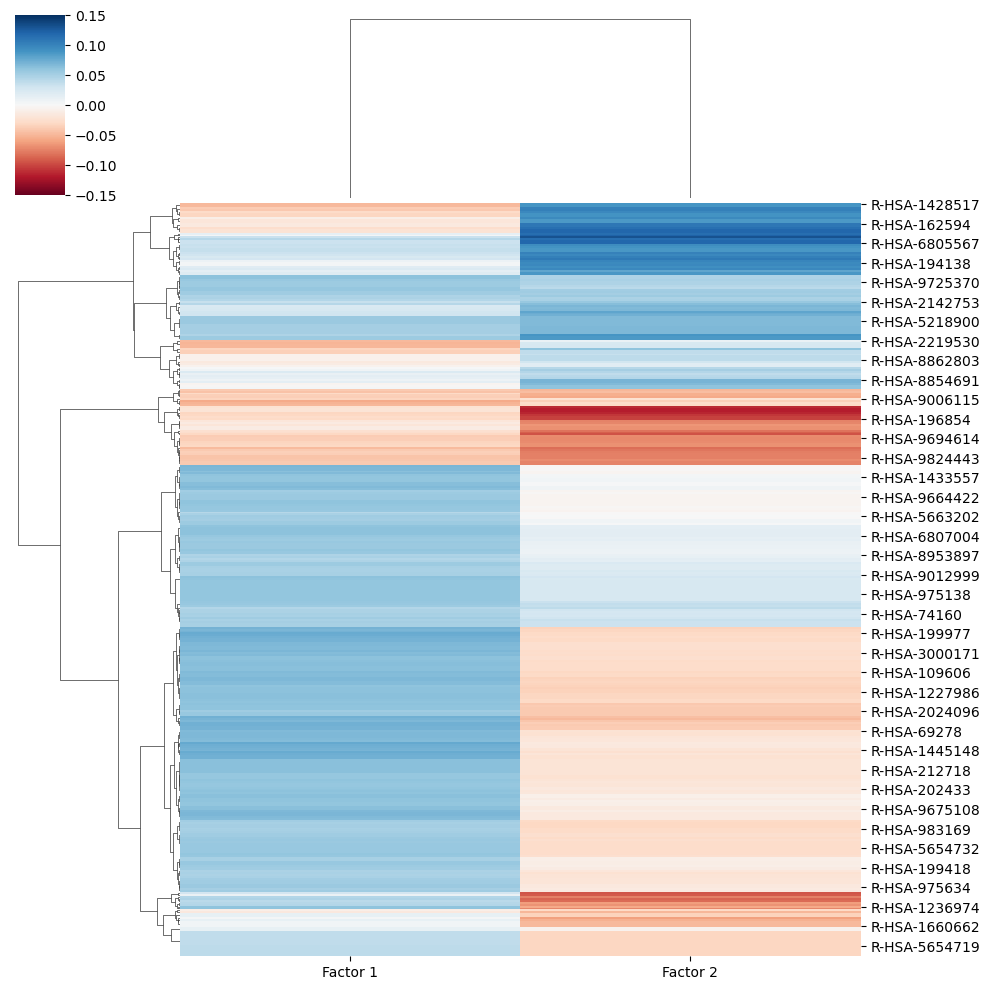

In [43]:
sns.clustermap(df_prot_path_r2, cmap='RdBu',method='ward',vmin=-0.15,vmax=0.15)

In [44]:
with open('reactome_updated.pkl','rb') as f:
    prot_pathways = pickle.load(f)

In [45]:
prot_pathway_mapping = prot_pathways.set_index(prot_pathways.index)['Pathway_name'].to_dict()
protpath_plt_df_r2 = df_prot_path_r2[['Factor 1','Factor 2']]
protpath_plt_df_r2['Pathway_name'] = protpath_plt_df_r2.index.map(prot_pathway_mapping)
protpath_plt_df_r2 = protpath_plt_df_r2.reset_index()
protpath_plt_df_r2.rename(columns={'index':'Pathway_ID'},inplace=True)
protpath_plt_df_r2.sort_values(by='Factor 1', ascending=False)

Pathway_ID  Factor 1  Factor 2  \
186   R-HSA-165159  0.076780 -0.014392   
91    R-HSA-199977  0.075351 -0.030148   
231  R-HSA-1852241  0.075132 -0.023489   
210   R-HSA-168638  0.074470 -0.029646   
343  R-HSA-5357956  0.073514 -0.019829   
..             ...       ...       ...   
215  R-HSA-5654733 -0.049458  0.025646   
279  R-HSA-1475029 -0.049827 -0.030207   
301   R-HSA-190236 -0.050902  0.024301   
153   R-HSA-913531 -0.052174 -0.027148   
104  R-HSA-9664323 -0.056905 -0.035943   

                                   Pathway_name  
186                             MTOR signalling  
91            ER to Golgi Anterograde Transport  
231        Organelle biogenesis and maintenance  
210                    NOD1/2 Signaling Pathway  
343  TNFR1-induced NF-kappa-B signaling pathway  
..                                          ...  
215      Negative regulation of FGFR4 signaling  
279      Reversible hydration of carbon dioxide  
301                           Signaling by FGFR  
153                        Interferon Signaling  
104              FCGR3A-mediated IL10 synthesis  

[386 rows x 4 columns]

In [46]:
prot_pathway_mapping = prot_pathways.set_index(prot_pathways.index)['Pathway_name'].to_dict()
protpath_plt_df_r2 = df_prot_path_r2[['Factor 1','Factor 2']]
protpath_plt_df_r2['Pathway_name'] = protpath_plt_df_r2.index.map(prot_pathway_mapping)
protpath_plt_df_r2 = protpath_plt_df_r2.reset_index()
protpath_plt_df_r2.rename(columns={'index':'Pathway_ID'},inplace=True)
protpath_plt_df_r2.sort_values(by='Factor 2', ascending=False)

Pathway_ID  Factor 1  Factor 2  \
351    R-HSA-75158  0.033386  0.130711   
233   R-HSA-389948  0.002989  0.121845   
116  R-HSA-6809371  0.032239  0.118742   
173  R-HSA-6805567  0.032239  0.118742   
138  R-HSA-5693538 -0.022125  0.118703   
..             ...       ...       ...   
253  R-HSA-8957275 -0.030634 -0.106991   
26   R-HSA-2024101 -0.022308 -0.111785   
281  R-HSA-9678108 -0.031899 -0.114304   
257  R-HSA-9660826 -0.020913 -0.117945   
35   R-HSA-9664424 -0.020913 -0.117945   

                                        Pathway_name  
351                                 TRAIL  signaling  
233                                   PD-1 signaling  
116              Formation of the cornified envelope  
173                                   Keratinization  
138                         Homology Directed Repair  
..                                               ...  
253       Post-translational protein phosphorylation  
26                                 CS/DS degradation  
281                             SARS-CoV-1 Infection  
257  Purinergic signaling in leishmaniasis infection  
35      Cell recruitment (pro-inflammatory response)  

[386 rows x 4 columns]

#### Decompose at rank=3, 4, 7, 20, 100

##### Decompose at rank=3

In [178]:
parafac2_tensor_r3 = parafac2([metab_kpca_PRF2,prot_kpca_PRF2],init='svd',rank=3)
weights_r3, factors_r3, projections_r3 = parafac2_tensor_r3
omics_mat_r3,Sk_r3, sample_mat_r3 = factors_r3

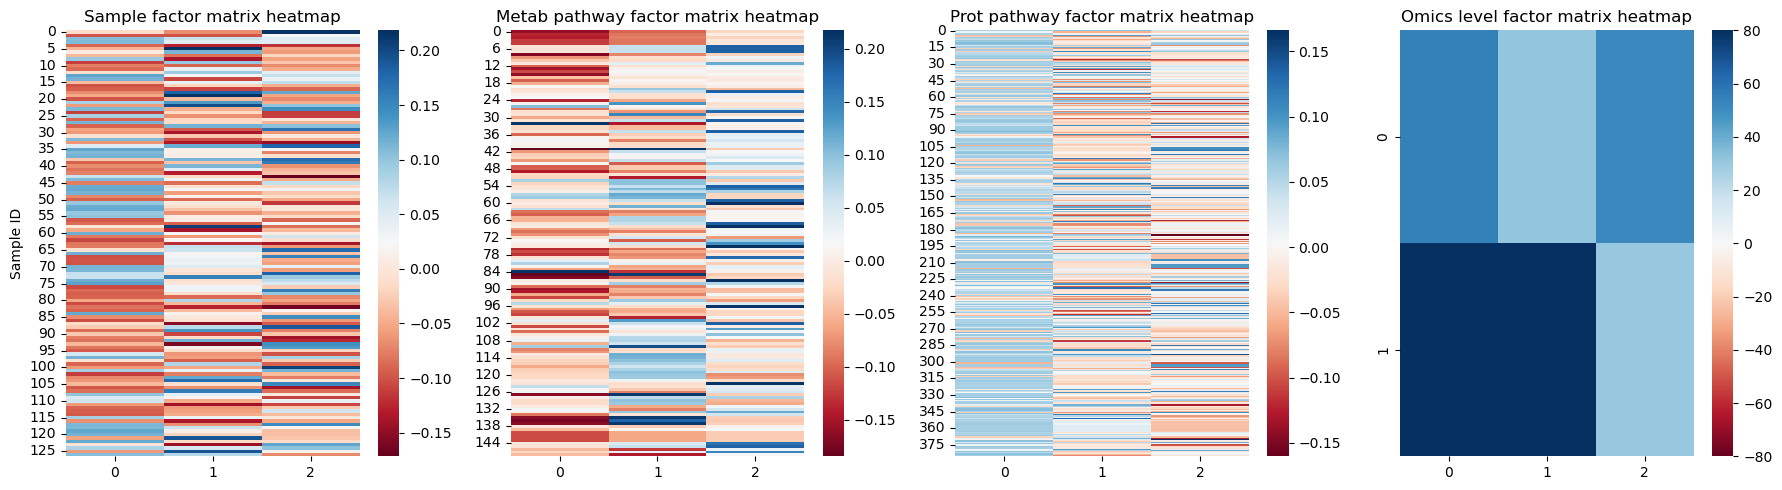

In [179]:
plt.figure(figsize=(18,5))

plt.subplot(1,4,1)
sns.heatmap(sample_mat_r3, cmap='RdBu')
plt.title('Sample factor matrix heatmap')
plt.ylabel('Sample ID')

plt.subplot(1,4,2)
sns.heatmap(projections_r3[0], cmap='RdBu')
plt.title('Metab pathway factor matrix heatmap')

plt.subplot(1,4,3)
sns.heatmap(projections_r3[1], cmap='RdBu')
plt.title('Prot pathway factor matrix heatmap')

plt.subplot(1,4,4)
sns.heatmap(omics_mat_r3, cmap='RdBu',vmin=-80,vmax=80)
plt.title('Omics level factor matrix heatmap')

plt.tight_layout()
plt.show()

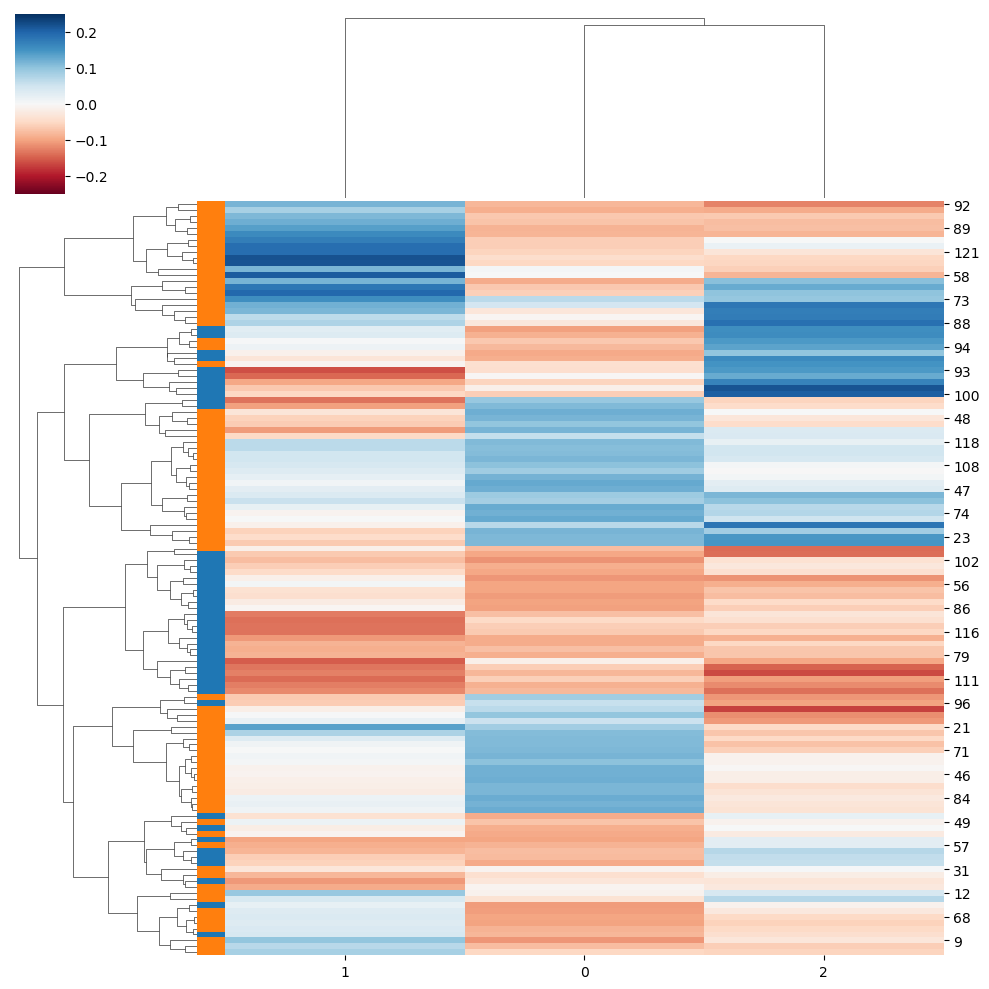

In [180]:
sns.clustermap(sample_mat_r3, 
               cmap='RdBu',method='complete',
               row_colors=["tab:blue" if i == 0 else "tab:orange" for i in metadata_binary],vmin=-0.25,vmax=0.25)

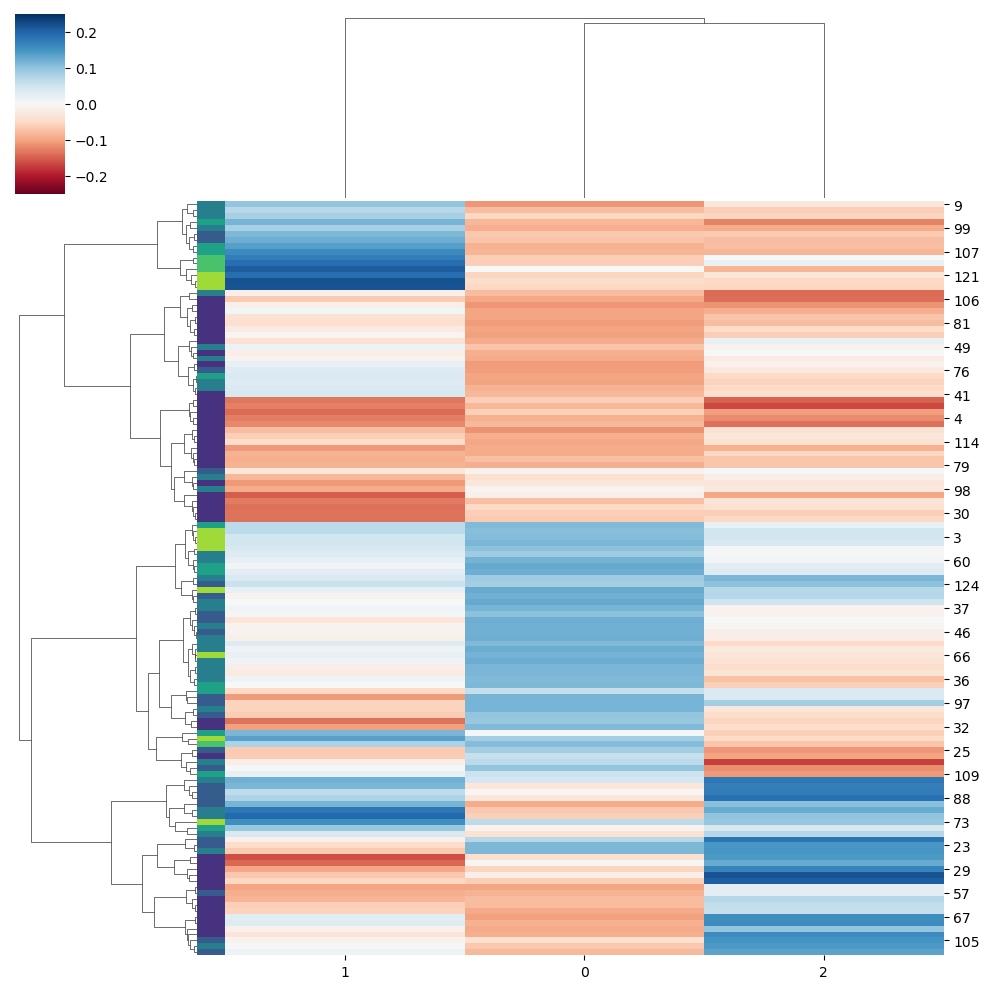

In [181]:
sns.clustermap(sample_mat_r3, 
               cmap='RdBu',
               method='ward',
               row_colors=who_row_colors,
               vmin=-0.25,vmax=0.25)

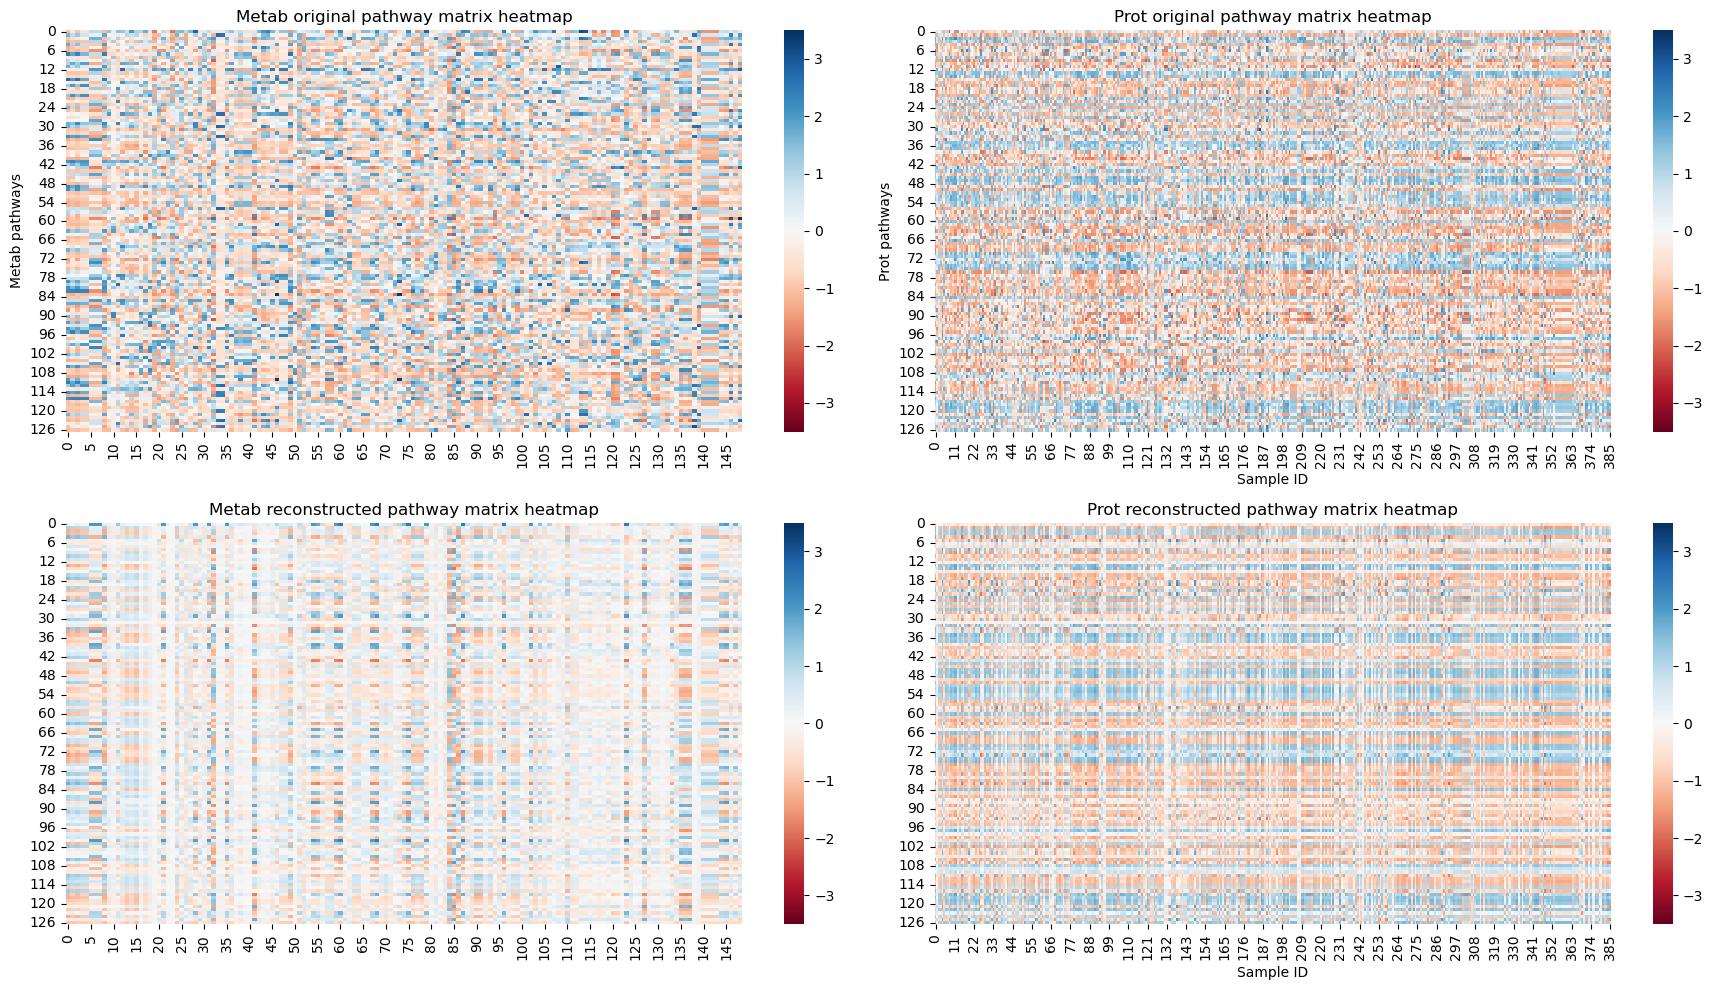

In [182]:
recon_slices_r3 = tl.parafac2_tensor.parafac2_to_slices(parafac2_tensor_r3)

plt.figure(figsize=(18,10))

plt.subplot(2,2,1)
sns.heatmap(metab_kpca_processed, cmap='RdBu',vmin=-3.5,vmax=3.5)
plt.title('Metab original pathway matrix heatmap')
plt.ylabel('Metab pathways')

plt.subplot(2,2,3)
sns.heatmap(recon_slices_r3[0].T, cmap='RdBu',vmin=-3.5,vmax=3.5)
plt.title('Metab reconstructed pathway matrix heatmap')

plt.subplot(2,2,2)
sns.heatmap(prot_kpca_processed, cmap='RdBu',vmin=-3.5,vmax=3.5)
plt.title('Prot original pathway matrix heatmap')
plt.ylabel('Prot pathways')
plt.xlabel('Sample ID')

plt.subplot(2,2,4)
sns.heatmap(recon_slices_r3[1].T, cmap='RdBu',vmin=-3.5,vmax=3.5)
plt.title('Prot reconstructed pathway matrix heatmap')
plt.xlabel('Sample ID')


plt.tight_layout()
plt.show()

##### Decompose at rank=3,4, 7, 20, 100

In [183]:
parafac2_tensor_r4 = parafac2([metab_kpca_PRF2,prot_kpca_PRF2],init='svd',rank=4)
weights_r4, factors_r4, projections_r4 = parafac2_tensor_r4
omics_mat_r4,Sk_r4, sample_mat_r4 = factors_r4

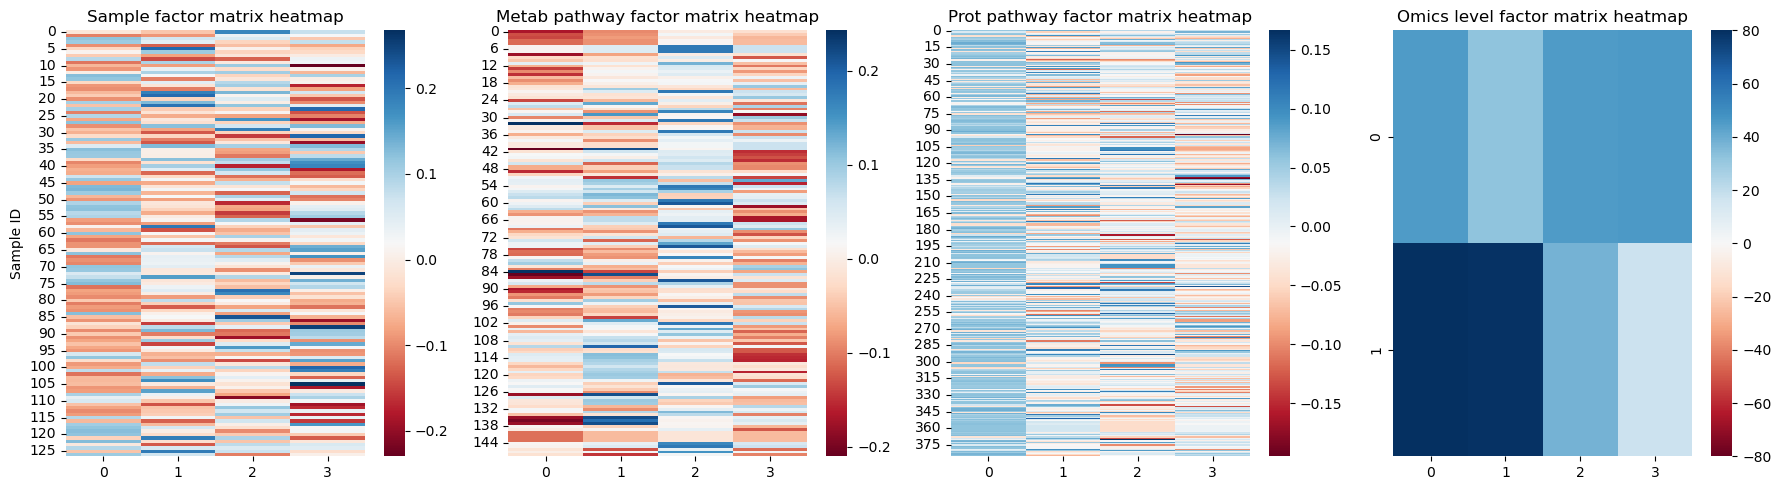

In [184]:
plt.figure(figsize=(18,5))

plt.subplot(1,4,1)
sns.heatmap(sample_mat_r4, cmap='RdBu')
plt.title('Sample factor matrix heatmap')
plt.ylabel('Sample ID')

plt.subplot(1,4,2)
sns.heatmap(projections_r4[0], cmap='RdBu')
plt.title('Metab pathway factor matrix heatmap')

plt.subplot(1,4,3)
sns.heatmap(projections_r4[1], cmap='RdBu')
plt.title('Prot pathway factor matrix heatmap')

plt.subplot(1,4,4)
sns.heatmap(omics_mat_r4, cmap='RdBu',vmin=-80,vmax=80)
plt.title('Omics level factor matrix heatmap')

plt.tight_layout()
plt.show()

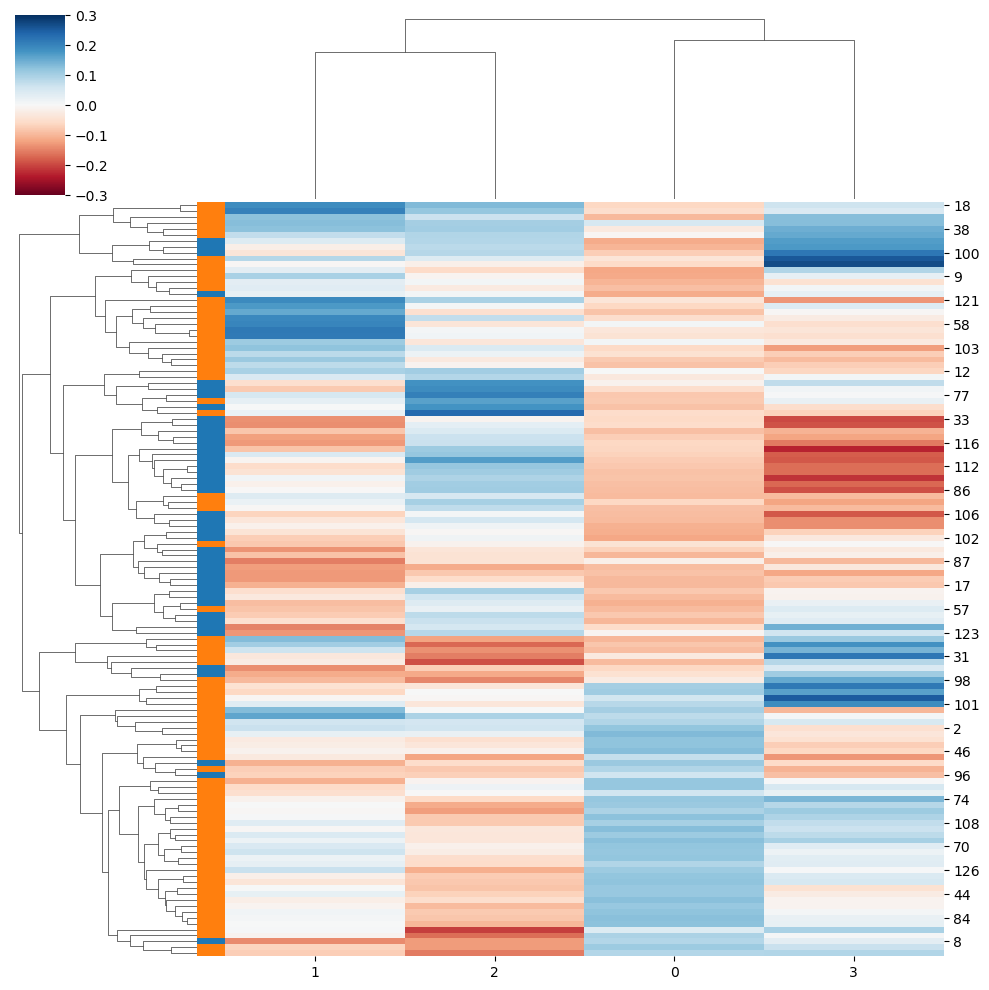

In [185]:
sns.clustermap(sample_mat_r4, 
               cmap='RdBu',
               row_colors=["tab:blue" if i == 0 else "tab:orange" for i in metadata_binary],
               vmin=-0.3,vmax=0.3)

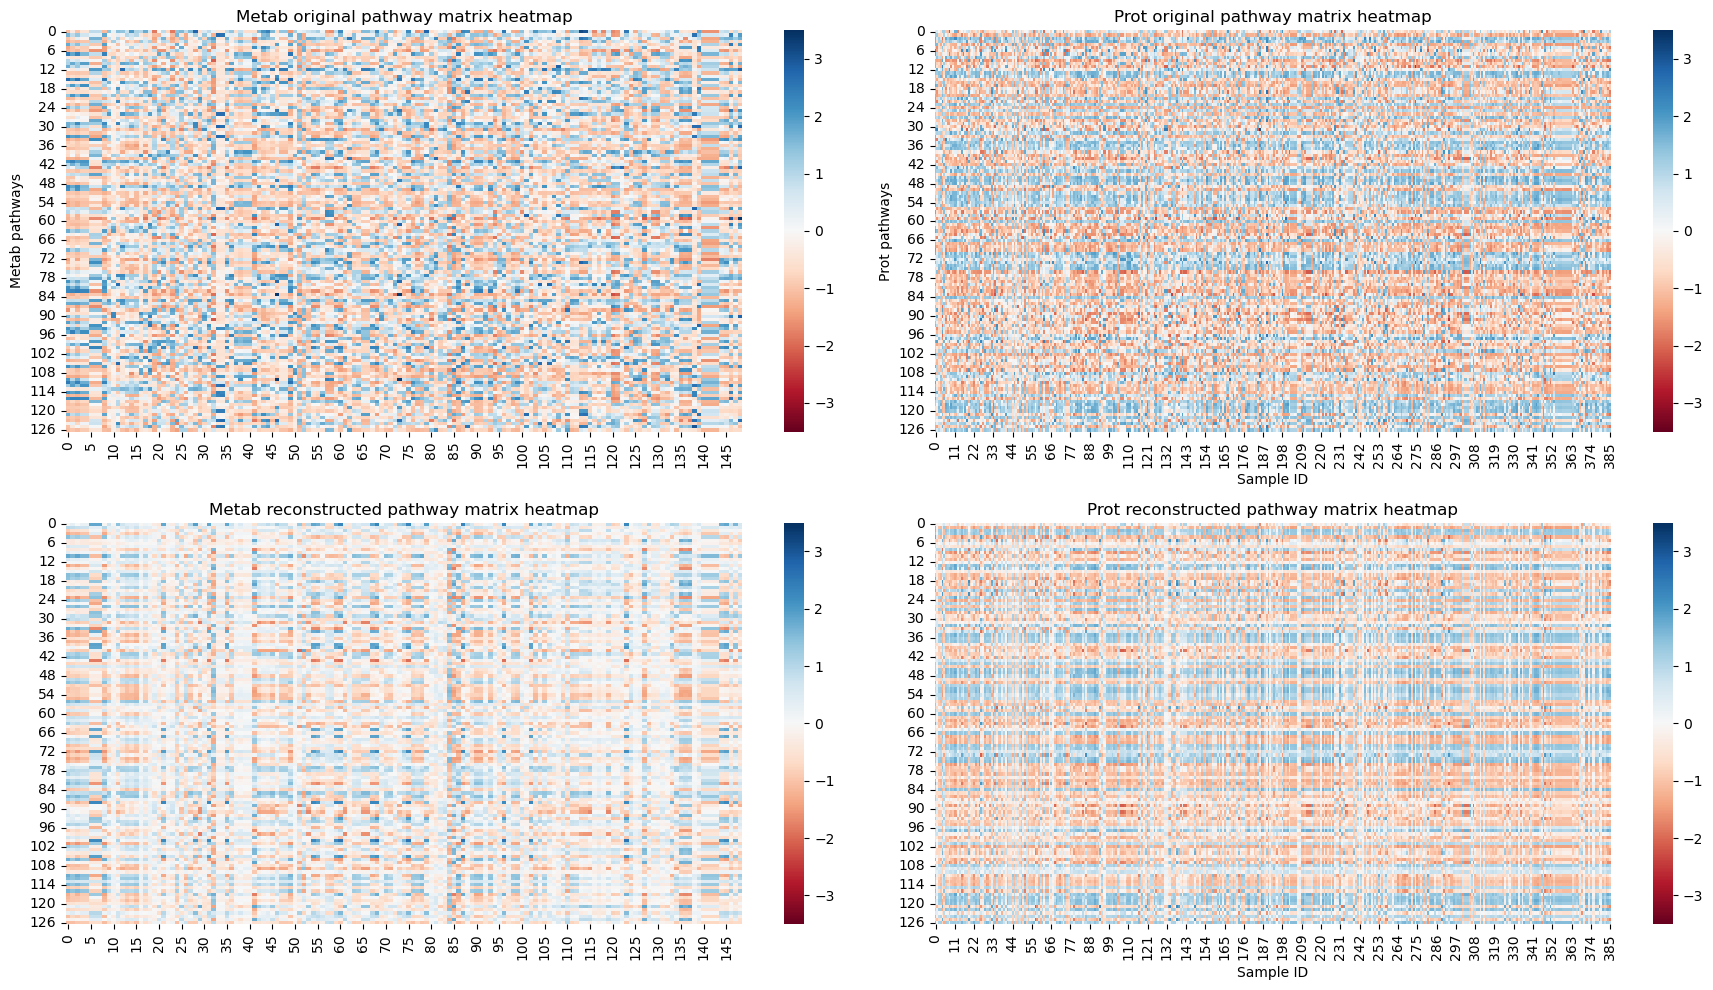

In [186]:
recon_slices_r4 = tl.parafac2_tensor.parafac2_to_slices(parafac2_tensor_r4)

plt.figure(figsize=(18,10))

plt.subplot(2,2,1)
sns.heatmap(metab_kpca_processed, cmap='RdBu',vmin=-3.5,vmax=3.5)
plt.title('Metab original pathway matrix heatmap')
plt.ylabel('Metab pathways')

plt.subplot(2,2,3)
sns.heatmap(recon_slices_r4[0].T, cmap='RdBu',vmin=-3.5,vmax=3.5)
plt.title('Metab reconstructed pathway matrix heatmap')

plt.subplot(2,2,2)
sns.heatmap(prot_kpca_processed, cmap='RdBu',vmin=-3.5,vmax=3.5)
plt.title('Prot original pathway matrix heatmap')
plt.ylabel('Prot pathways')
plt.xlabel('Sample ID')

plt.subplot(2,2,4)
sns.heatmap(recon_slices_r4[1].T, cmap='RdBu',vmin=-3.5,vmax=3.5)
plt.title('Prot reconstructed pathway matrix heatmap')
plt.xlabel('Sample ID')


plt.tight_layout()
plt.show()

##### Decompose at rank=7

In [187]:
parafac2_tensor_r7 = parafac2([metab_kpca_PRF2,prot_kpca_PRF2],init='svd',rank=7)
weights_r7, factors_r7, projections_r7 = parafac2_tensor_r7
omics_mat_r7,Sk_r7, sample_mat_r7 = factors_r7

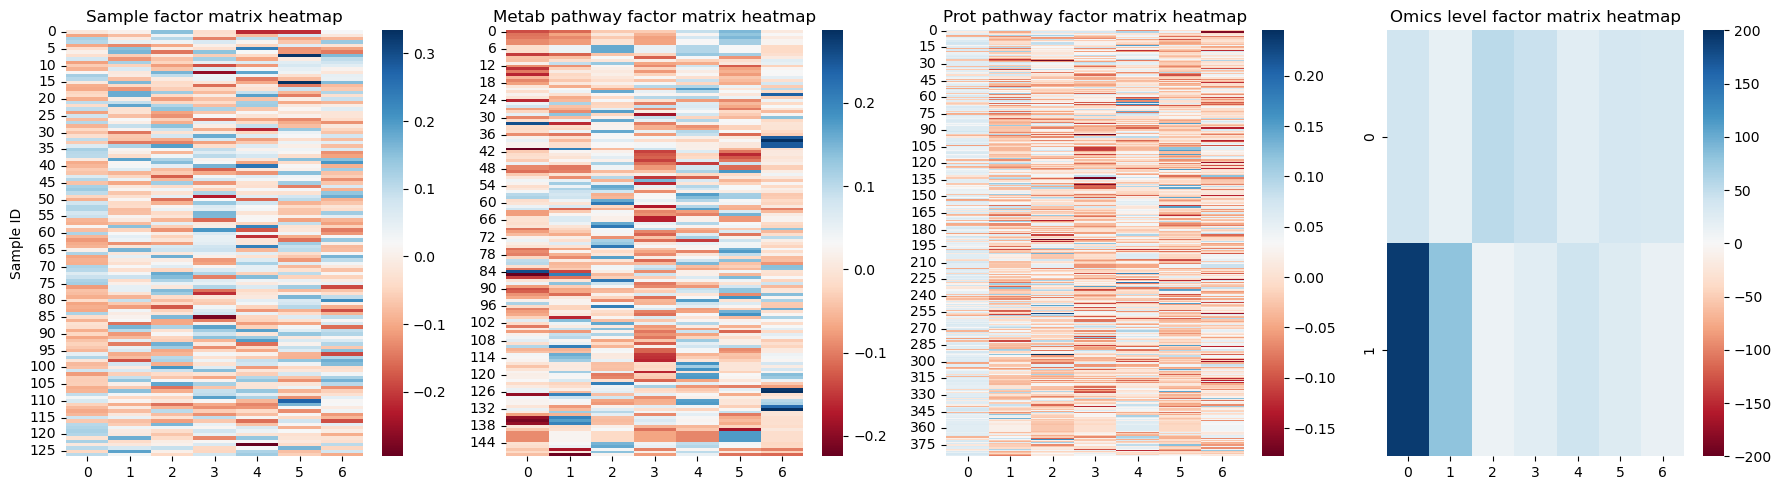

In [188]:
plt.figure(figsize=(18,5))

plt.subplot(1,4,1)
sns.heatmap(sample_mat_r7, cmap='RdBu')
plt.title('Sample factor matrix heatmap')
plt.ylabel('Sample ID')

plt.subplot(1,4,2)
sns.heatmap(projections_r7[0], cmap='RdBu')
plt.title('Metab pathway factor matrix heatmap')

plt.subplot(1,4,3)
sns.heatmap(projections_r7[1], cmap='RdBu')
plt.title('Prot pathway factor matrix heatmap')

plt.subplot(1,4,4)
sns.heatmap(omics_mat_r7, cmap='RdBu',vmin=-200,vmax=200)
plt.title('Omics level factor matrix heatmap')

plt.tight_layout()
plt.show()

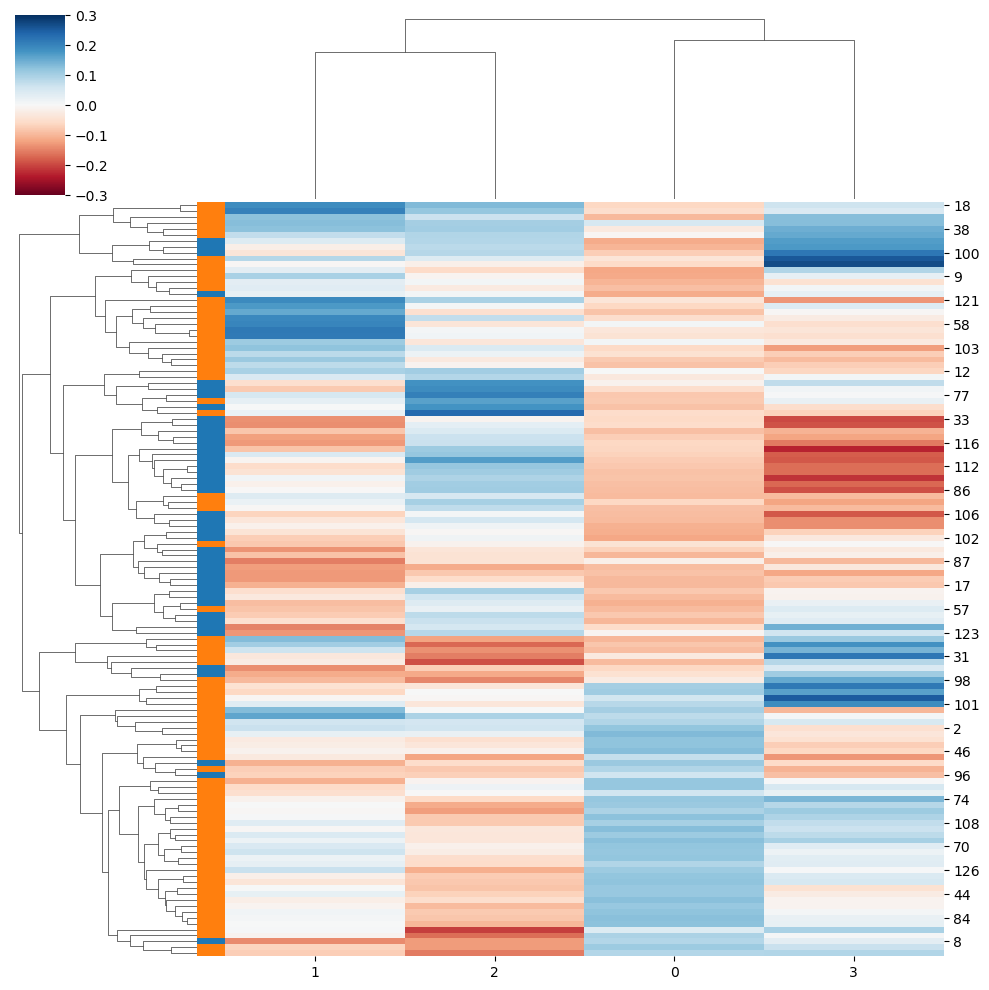

In [189]:
sns.clustermap(sample_mat_r4, 
               cmap='RdBu',
               row_colors=["tab:blue" if i == 0 else "tab:orange" for i in metadata_binary],
               vmin=-0.3,vmax=0.3)

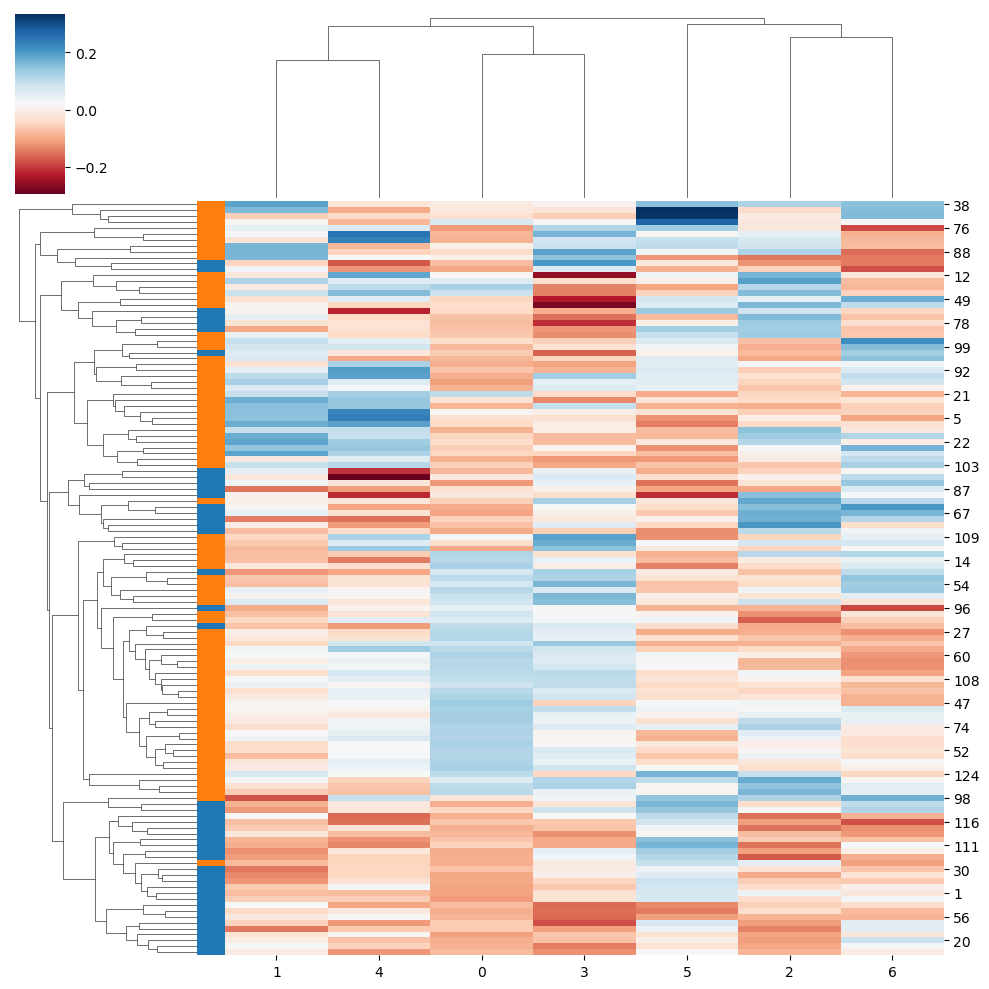

In [190]:
weights, factors, projections = parafac2([metab_kpca_PRF2,prot_kpca_PRF2],init='svd',rank=7)
omics_mat,Sk, sample_mat = factors
sns.clustermap(sample_mat, cmap='RdBu',row_colors=["tab:blue" if i == 0 else "tab:orange" for i in metadata_binary])

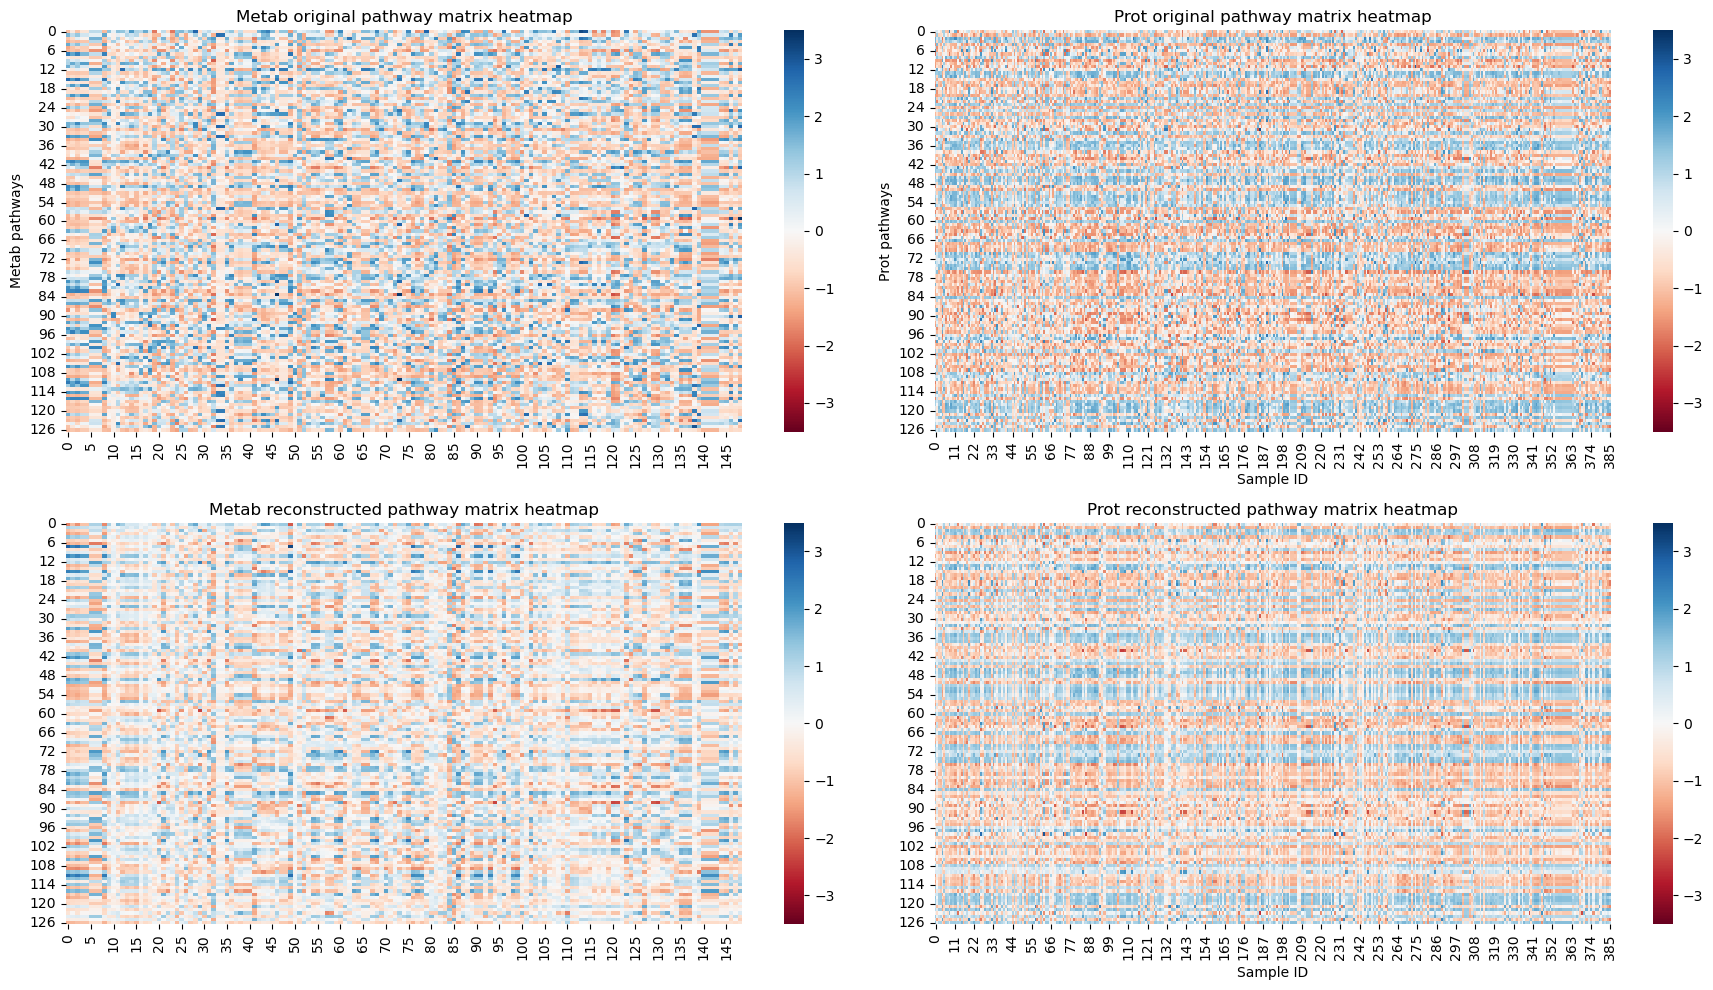

In [191]:
recon_slices_r7 = tl.parafac2_tensor.parafac2_to_slices(parafac2_tensor_r7)

plt.figure(figsize=(18,10))

plt.subplot(2,2,1)
sns.heatmap(metab_kpca_processed, cmap='RdBu',vmin=-3.5,vmax=3.5)
plt.title('Metab original pathway matrix heatmap')
plt.ylabel('Metab pathways')

plt.subplot(2,2,3)
sns.heatmap(recon_slices_r7[0].T, cmap='RdBu',vmin=-3.5,vmax=3.5)
plt.title('Metab reconstructed pathway matrix heatmap')

plt.subplot(2,2,2)
sns.heatmap(prot_kpca_processed, cmap='RdBu',vmin=-3.5,vmax=3.5)
plt.title('Prot original pathway matrix heatmap')
plt.ylabel('Prot pathways')
plt.xlabel('Sample ID')

plt.subplot(2,2,4)
sns.heatmap(recon_slices_r7[1].T, cmap='RdBu',vmin=-3.5,vmax=3.5)
plt.title('Prot reconstructed pathway matrix heatmap')
plt.xlabel('Sample ID')


plt.tight_layout()
plt.show()

##### Decompose at rank=10

In [192]:
parafac2_tensor_r10 = parafac2([metab_kpca_PRF2,prot_kpca_PRF2],init='svd',rank=10)
weights_r10, factors_r10, projections_r10 = parafac2_tensor_r10
omics_mat_r10,Sk_r10, sample_mat_r10 = factors_r10

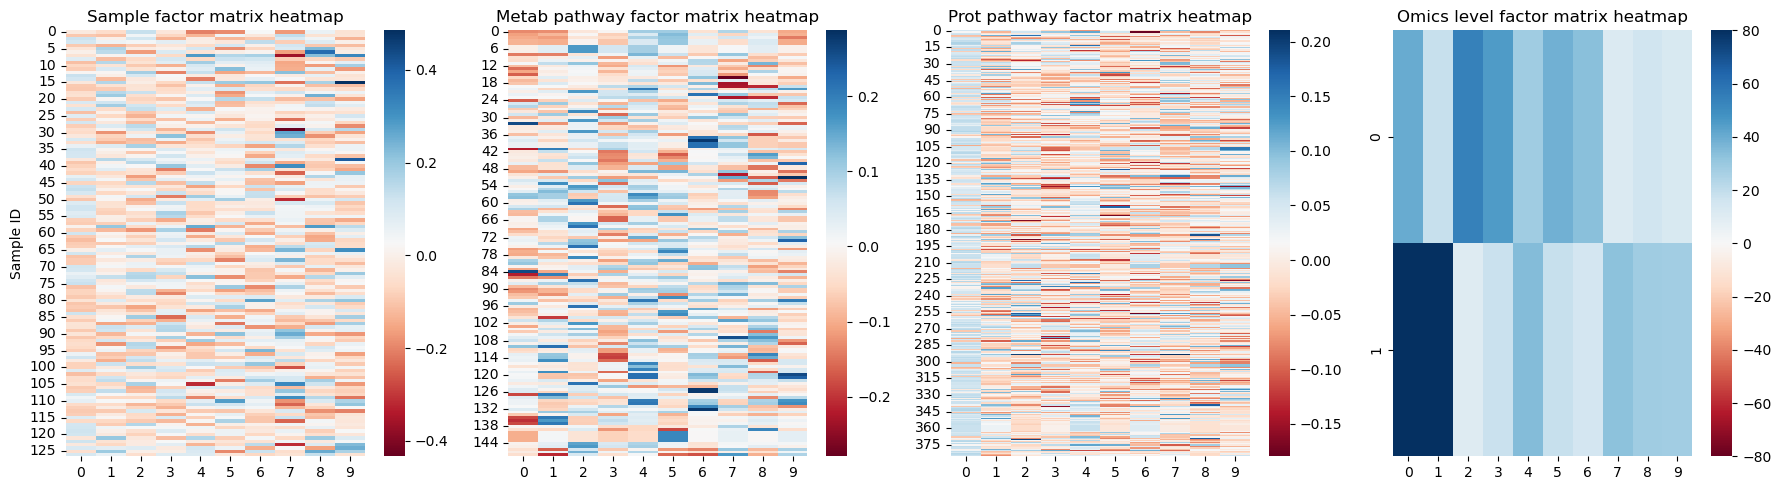

In [193]:
plt.figure(figsize=(18,5))

plt.subplot(1,4,1)
sns.heatmap(sample_mat_r10, cmap='RdBu')
plt.title('Sample factor matrix heatmap')
plt.ylabel('Sample ID')

plt.subplot(1,4,2)
sns.heatmap(projections_r10[0], cmap='RdBu')
plt.title('Metab pathway factor matrix heatmap')

plt.subplot(1,4,3)
sns.heatmap(projections_r10[1], cmap='RdBu')
plt.title('Prot pathway factor matrix heatmap')

plt.subplot(1,4,4)
sns.heatmap(omics_mat_r10, cmap='RdBu',vmin=-80,vmax=80)
plt.title('Omics level factor matrix heatmap')

plt.tight_layout()
plt.show()

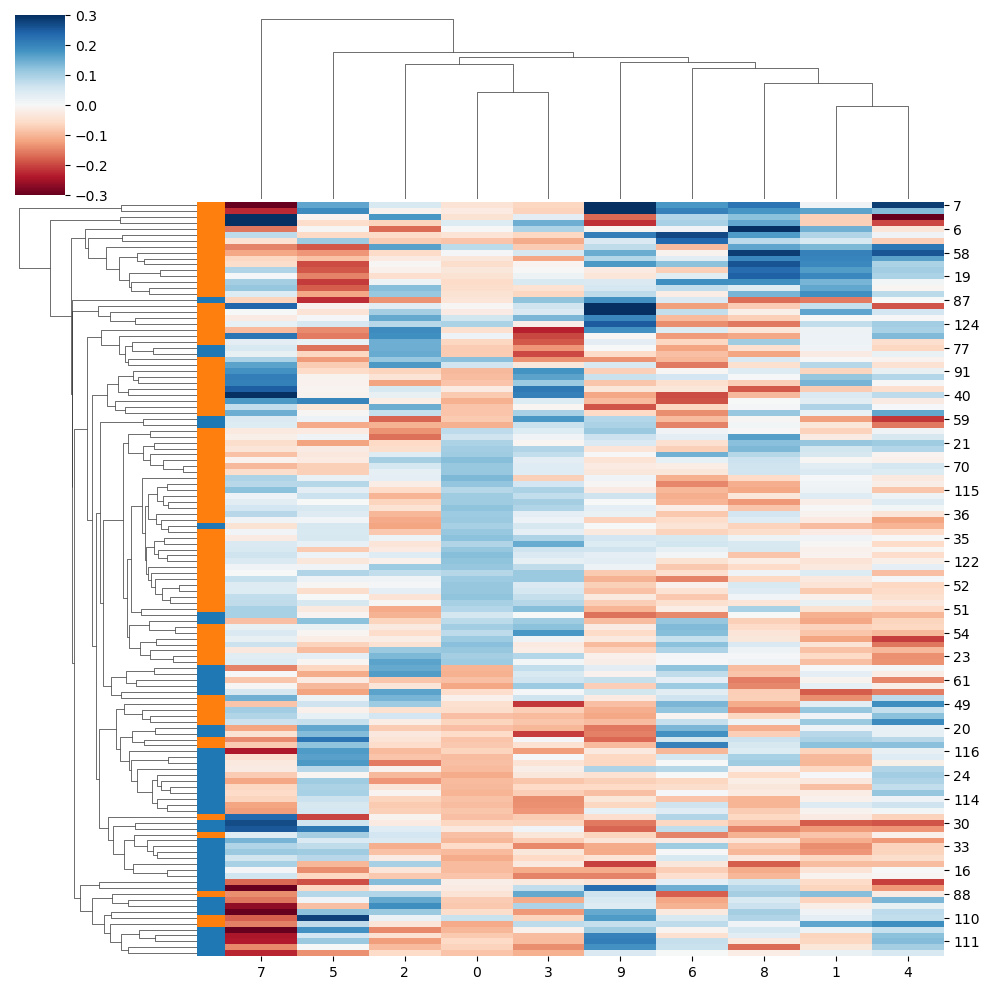

In [194]:
sns.clustermap(sample_mat_r10, 
               cmap='RdBu',
               row_colors=["tab:blue" if i == 0 else "tab:orange" for i in metadata_binary],
               vmin=-0.3,vmax=0.3)

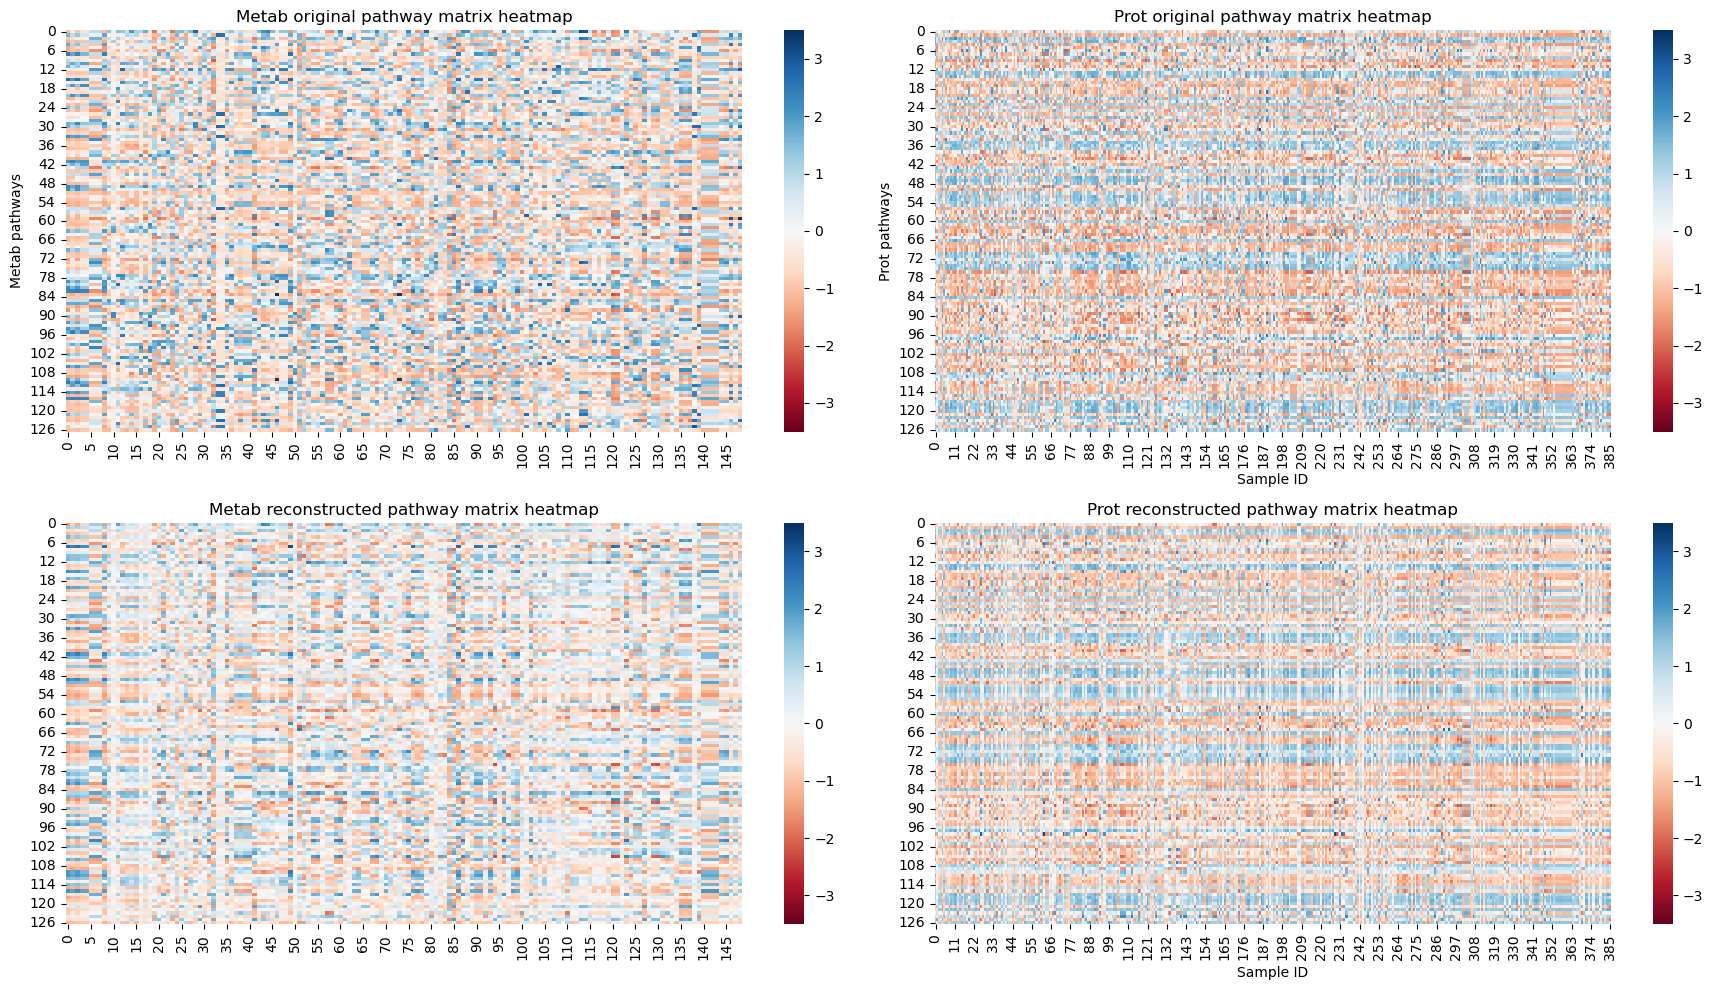

In [195]:
recon_slices_r10 = tl.parafac2_tensor.parafac2_to_slices(parafac2_tensor_r10)

plt.figure(figsize=(18,10))

plt.subplot(2,2,1)
sns.heatmap(metab_kpca_processed, cmap='RdBu',vmin=-3.5,vmax=3.5)
plt.title('Metab original pathway matrix heatmap')
plt.ylabel('Metab pathways')

plt.subplot(2,2,3)
sns.heatmap(recon_slices_r10[0].T, cmap='RdBu',vmin=-3.5,vmax=3.5)
plt.title('Metab reconstructed pathway matrix heatmap')

plt.subplot(2,2,2)
sns.heatmap(prot_kpca_processed, cmap='RdBu',vmin=-3.5,vmax=3.5)
plt.title('Prot original pathway matrix heatmap')
plt.ylabel('Prot pathways')
plt.xlabel('Sample ID')

plt.subplot(2,2,4)
sns.heatmap(recon_slices_r10[1].T, cmap='RdBu',vmin=-3.5,vmax=3.5)
plt.title('Prot reconstructed pathway matrix heatmap')
plt.xlabel('Sample ID')


plt.tight_layout()
plt.show()

##### Decompose at rank = 20

In [196]:
parafac2_tensor_r20 = parafac2([metab_kpca_PRF2,prot_kpca_PRF2],init='svd',rank=20)
weights_r20, factors_r20, projections_r20 = parafac2_tensor_r20
omics_mat_r20,Sk_r20, sample_mat_r20 = factors_r20

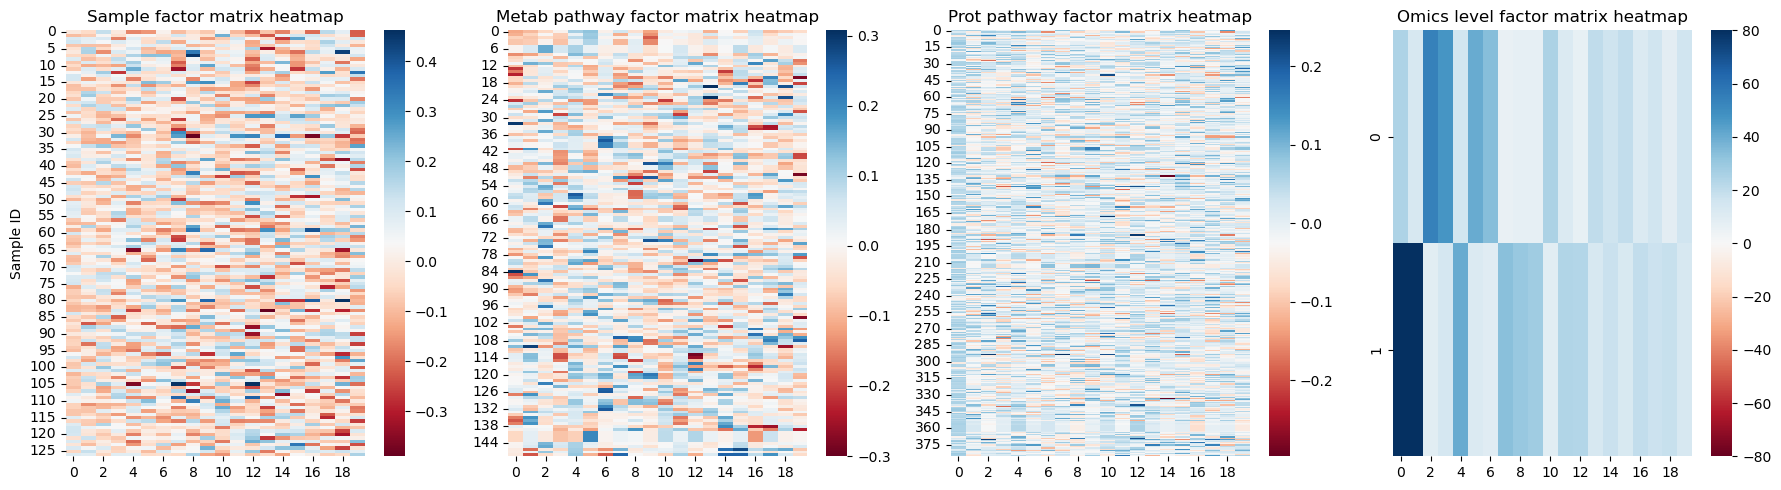

In [197]:
plt.figure(figsize=(18,5))

plt.subplot(1,4,1)
sns.heatmap(sample_mat_r20, cmap='RdBu')
plt.title('Sample factor matrix heatmap')
plt.ylabel('Sample ID')

plt.subplot(1,4,2)
sns.heatmap(projections_r20[0], cmap='RdBu')
plt.title('Metab pathway factor matrix heatmap')

plt.subplot(1,4,3)
sns.heatmap(projections_r20[1], cmap='RdBu')
plt.title('Prot pathway factor matrix heatmap')

plt.subplot(1,4,4)
sns.heatmap(omics_mat_r20, cmap='RdBu',vmin=-80,vmax=80)
plt.title('Omics level factor matrix heatmap')

plt.tight_layout()
plt.show()

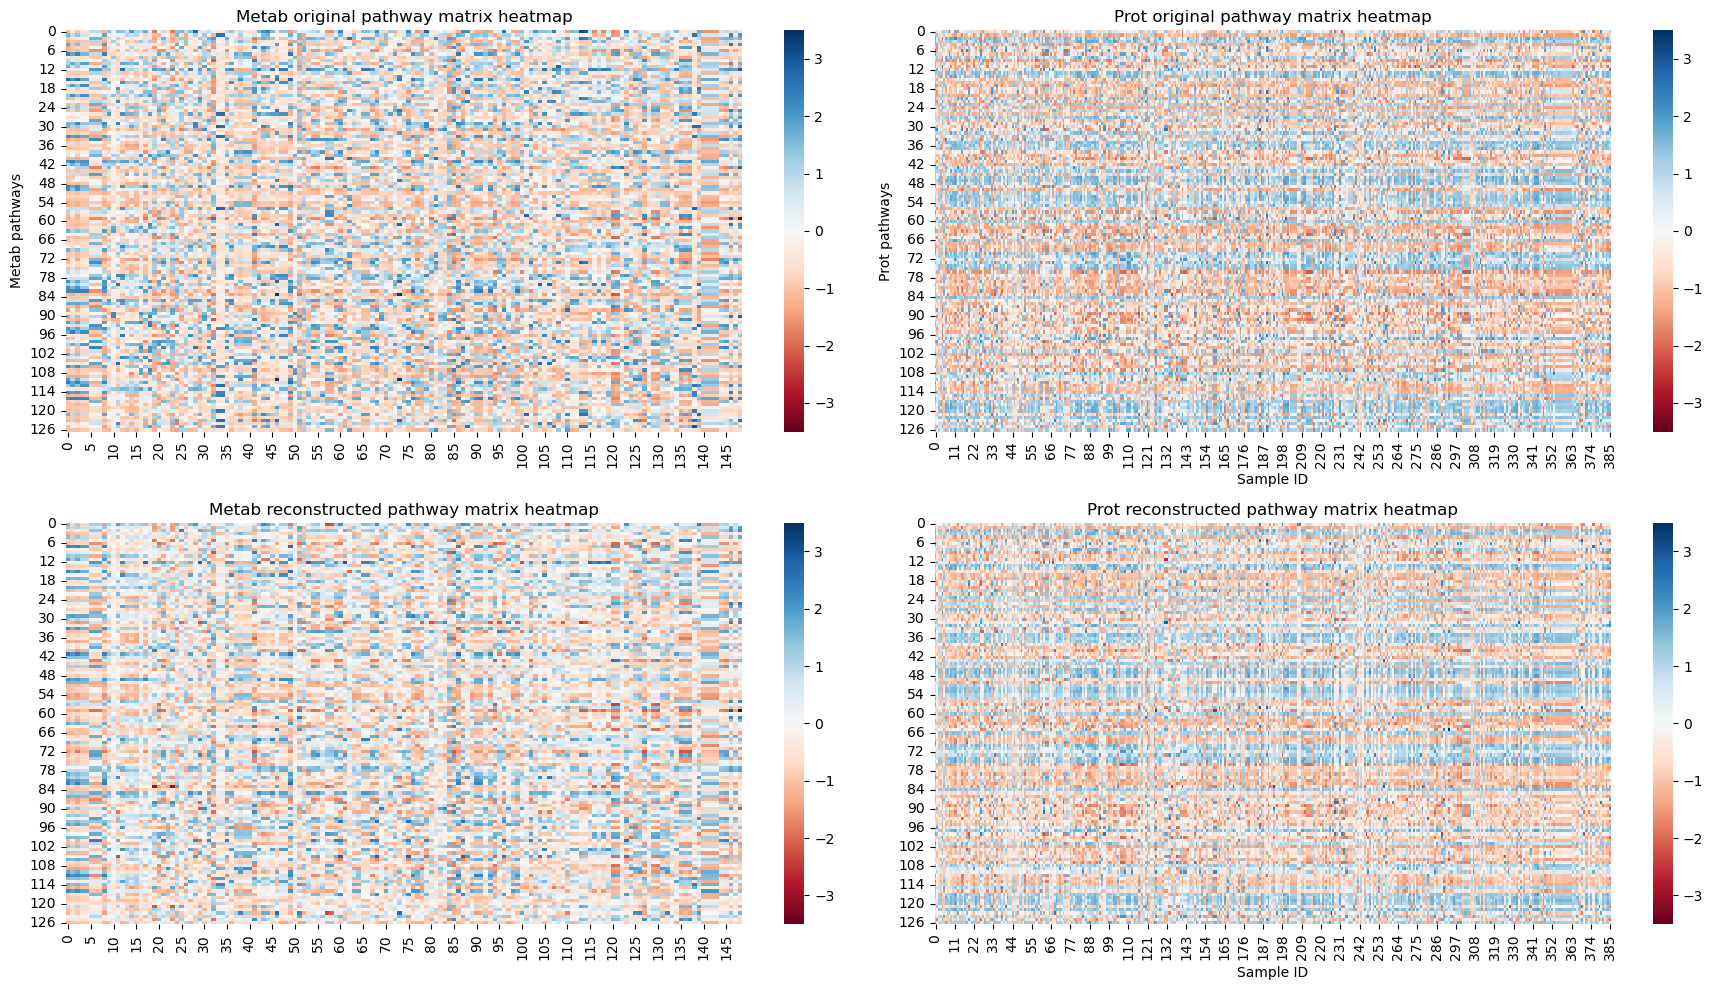

In [198]:
recon_slices_r20 = tl.parafac2_tensor.parafac2_to_slices(parafac2_tensor_r20)

plt.figure(figsize=(18,10))

plt.subplot(2,2,1)
sns.heatmap(metab_kpca_processed, cmap='RdBu',vmin=-3.5,vmax=3.5)
plt.title('Metab original pathway matrix heatmap')
plt.ylabel('Metab pathways')

plt.subplot(2,2,3)
sns.heatmap(recon_slices_r20[0].T, cmap='RdBu',vmin=-3.5,vmax=3.5)
plt.title('Metab reconstructed pathway matrix heatmap')

plt.subplot(2,2,2)
sns.heatmap(prot_kpca_processed, cmap='RdBu',vmin=-3.5,vmax=3.5)
plt.title('Prot original pathway matrix heatmap')
plt.ylabel('Prot pathways')
plt.xlabel('Sample ID')

plt.subplot(2,2,4)
sns.heatmap(recon_slices_r20[1].T, cmap='RdBu',vmin=-3.5,vmax=3.5)
plt.title('Prot reconstructed pathway matrix heatmap')
plt.xlabel('Sample ID')


plt.tight_layout()
plt.show()

##### Decompose at rank = 100

In [199]:
parafac2_tensor_r100 = parafac2([metab_kpca_PRF2,prot_kpca_PRF2],init='svd',rank=100)
weights_r100, factors_r100, projections_r100 = parafac2_tensor_r100
omics_mat_r100,Sk_r100, sample_mat_r100 = factors_r100

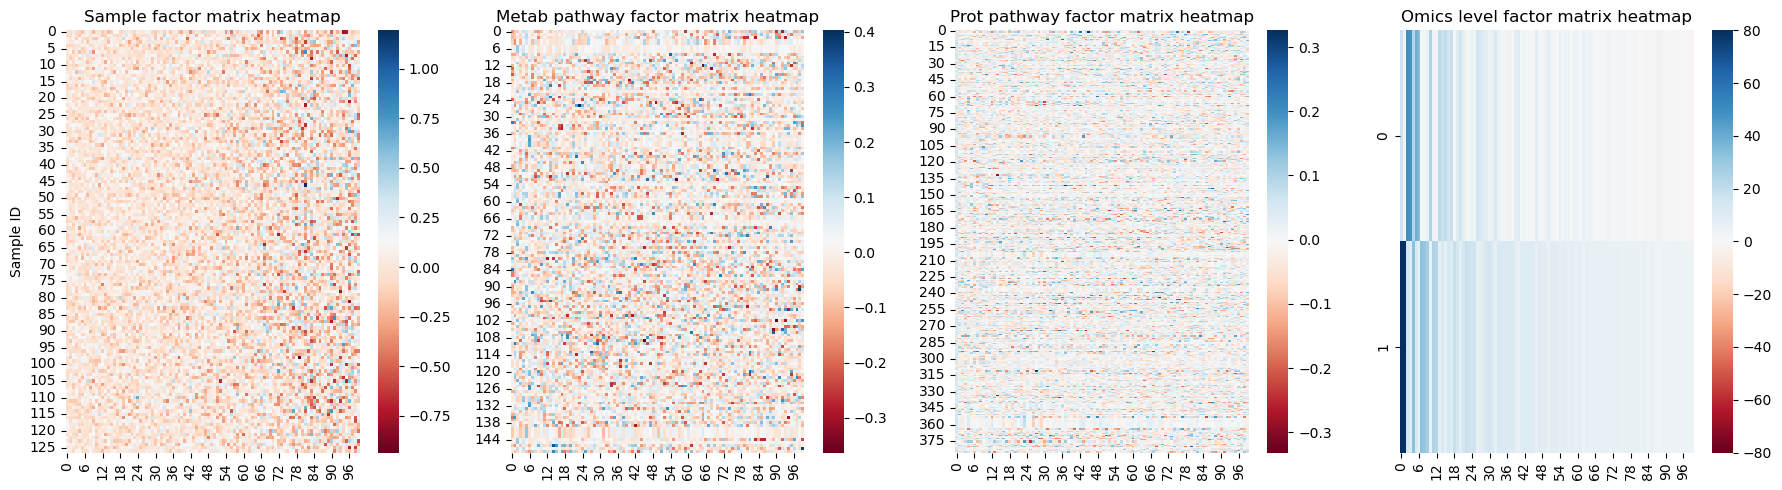

In [200]:
plt.figure(figsize=(18,5))

plt.subplot(1,4,1)
sns.heatmap(sample_mat_r100, cmap='RdBu')
plt.title('Sample factor matrix heatmap')
plt.ylabel('Sample ID')

plt.subplot(1,4,2)
sns.heatmap(projections_r100[0], cmap='RdBu')
plt.title('Metab pathway factor matrix heatmap')

plt.subplot(1,4,3)
sns.heatmap(projections_r100[1], cmap='RdBu')
plt.title('Prot pathway factor matrix heatmap')

plt.subplot(1,4,4)
sns.heatmap(omics_mat_r100, cmap='RdBu',vmin=-80,vmax=80)
plt.title('Omics level factor matrix heatmap')

plt.tight_layout()
plt.show()

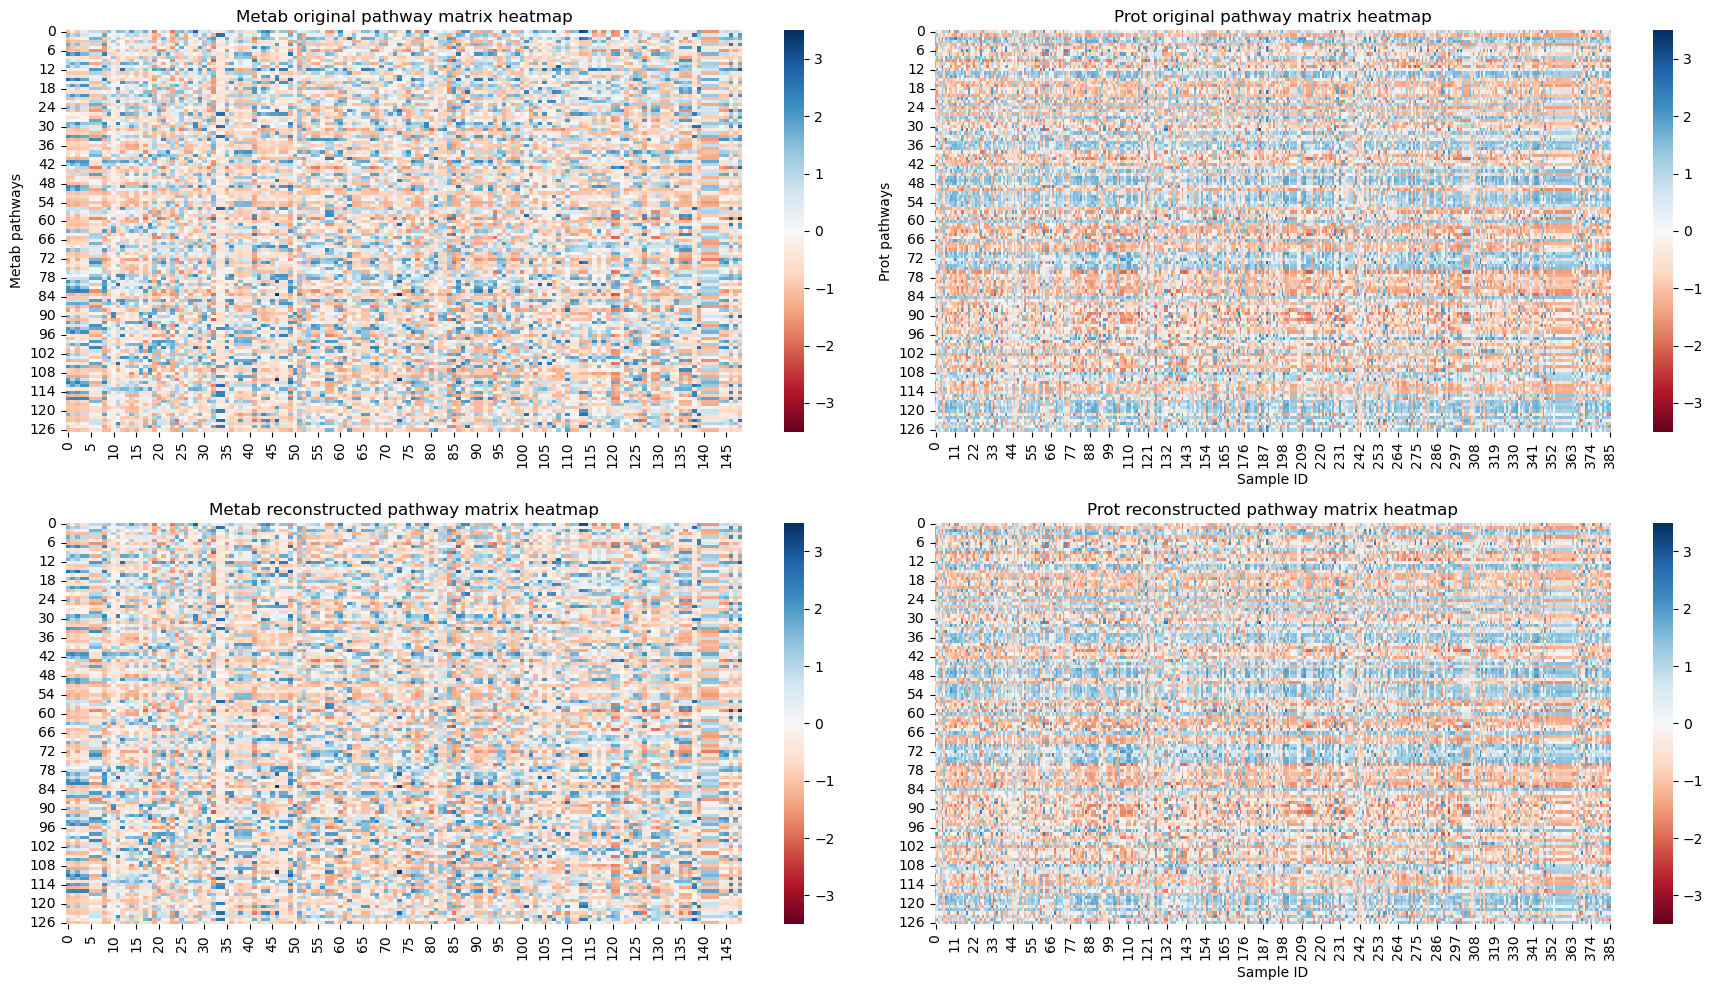

In [201]:
recon_slices_r100 = tl.parafac2_tensor.parafac2_to_slices(parafac2_tensor_r100)

plt.figure(figsize=(18,10))

plt.subplot(2,2,1)
sns.heatmap(metab_kpca_processed, cmap='RdBu',vmin=-3.5,vmax=3.5)
plt.title('Metab original pathway matrix heatmap')
plt.ylabel('Metab pathways')

plt.subplot(2,2,3)
sns.heatmap(recon_slices_r100[0].T, cmap='RdBu',vmin=-3.5,vmax=3.5)
plt.title('Metab reconstructed pathway matrix heatmap')

plt.subplot(2,2,2)
sns.heatmap(prot_kpca_processed, cmap='RdBu',vmin=-3.5,vmax=3.5)
plt.title('Prot original pathway matrix heatmap')
plt.ylabel('Prot pathways')
plt.xlabel('Sample ID')

plt.subplot(2,2,4)
sns.heatmap(recon_slices_r100[1].T, cmap='RdBu',vmin=-3.5,vmax=3.5)
plt.title('Prot reconstructed pathway matrix heatmap')
plt.xlabel('Sample ID')


plt.tight_layout()
plt.show()

#### Feature selection

In [74]:
path_facs_dfs = bootstrap_feature_select_pr2([metab_kpca,prot_kpca])

In [75]:
metab_fac1_bs = path_facs_dfs[0][0]
metab_fac2_bs = path_facs_dfs[0][1]
prot_fac1_bs = path_facs_dfs[1][0]
prot_fac2_bs = path_facs_dfs[1][1]

In [76]:
import plotly.graph_objects as go

pathway_num = metab_fac1_bs.shape[1]

fig = go.Figure()

# Plot mean pathway factor scores for Pathway Factor 1
metab_fac1_mean, metab_fac1_cis = feature_select_bs_ci(metab_fac1_bs)
fig.add_trace(go.Scatter(
    x=metab_kpca.columns,
    y=metab_fac1_mean,
    mode='markers',
    name='Mean Metab Pathway Factor 1 Score ± 95% CI',
    error_y=dict(type='data', array=metab_fac1_cis[:, 1]- metab_fac1_mean, arrayminus=metab_fac1_mean - metab_fac1_cis[:, 0]),
    text=metab_fac1_bs.columns,
    hoverinfo='text'
))

# Plot mean pathway factor scores for Pathway Factor 2
metab_fac2_mean, metab_fac2_cis = feature_select_bs_ci(metab_fac2_bs)
fig.add_trace(go.Scatter(
    x=metab_kpca.columns,
    y=metab_fac2_mean,
    mode='markers',
    name='Mean Metab Pathway Factor 2 Score ± 95% CI',
    error_y=dict(type='data', array=metab_fac2_cis[:, 1] - metab_fac2_mean, arrayminus=metab_fac2_mean-metab_fac2_cis[:, 0]),
    text=metab_fac2_bs.columns,
    hoverinfo='text'
))

fig.update_layout(
    title="Metab Pathway Factor Matrix Scores with 95% Confidence Intervals",
    xaxis_title="Pathways",
    yaxis_title="Pathway Factor Score",
    xaxis=dict(tickmode='linear'),  
    showlegend=True,
    width=1000,  
    height=600   
)

fig.show()

In [77]:
metab_fac1_significant_pathways = significant_pathways(metab_fac1_bs)
metab_fac2_significant_pathways = significant_pathways(metab_fac2_bs)
print(len(metab_fac1_significant_pathways),len(metab_fac2_significant_pathways))

79 50


In [78]:
pathway_num = prot_fac1_bs.shape[1]

fig = go.Figure()

# Plot mean pathway factor scores for Pathway Factor 1
prot_fac1_mean, prot_fac1_cis = feature_select_bs_ci(prot_fac1_bs)
fig.add_trace(go.Scatter(
    x=prot_fac1_bs.columns,
    y=prot_fac1_mean,
    mode='markers',
    name='Mean Prot Pathway Factor 1 Score ± 95% CI',
    error_y=dict(type='data', array=prot_fac1_cis[:, 1]- prot_fac1_mean, arrayminus=prot_fac1_mean - prot_fac1_cis[:, 0]),
    text=prot_fac1_bs.columns,
    hoverinfo='text'
))

# Plot mean pathway factor scores for Pathway Factor 2
prot_fac2_mean, prot_fac2_cis = feature_select_bs_ci(prot_fac2_bs)
fig.add_trace(go.Scatter(
    x=prot_fac1_bs.columns,
    y=prot_fac2_mean,
    mode='markers',
    name='Mean Prot Pathway Factor 2 Score ± 95% CI',
    error_y=dict(type='data', array=prot_fac2_cis[:, 1] - prot_fac2_mean, arrayminus=prot_fac2_mean-prot_fac2_cis[:, 0]),
    text=prot_fac2_bs.columns,
    hoverinfo='text'
))

fig.update_layout(
    title="Prot Pathway Factor Matrix Scores with 95% Confidence Intervals",
    xaxis_title="Pathways",
    yaxis_title="Pathway Factor Score",
    xaxis=dict(tickmode='linear'),  
    showlegend=True,
    width=1000,  
    height=600   
)

fig.show()

In [79]:
prot_fac1_significant_pathways = significant_pathways(prot_fac1_bs)
prot_fac2_significant_pathways = significant_pathways(prot_fac2_bs)
print(len(prot_fac1_significant_pathways),len(prot_fac2_significant_pathways))

365 300


- Second method

In [80]:
metab_facs_bs = {0: metab_fac1_bs, 1: metab_fac2_bs}
prot_facs_bs = {0: prot_fac1_bs, 1: prot_fac2_bs}

In [81]:
metab_pathways  = sspa.process_reactome(organism="Homo sapiens")
metab_pathway_dict = dict(zip(metab_pathways.index,metab_pathways['Pathway_name'].to_list()))

with open('reactome_updated.pkl','rb') as f:
    prot_pathways = pickle.load(f)

prot_pathway_dict = dict(zip(prot_pathways.index,prot_pathways['Pathway_name'].to_list()))

In [82]:
p2_all_metab_pseudoz = combined_pseudoz(metab_facs_bs)

In [167]:
p2_all_metab_f1_pseudoz = p2_all_metab_pseudoz[['Factor 1']].abs().sort_values(by='Factor 1',ascending=False)
p2_all_metab_f1_pseudoz=p2_all_metab_f1_pseudoz.rename(columns={'Factor 1':'Combined'})
p2_all_metab_f1_sigpath = significant_pseudoz(p2_all_metab_f1_pseudoz,metab_pathway_dict,95)
p2_all_metab_f1_sigpath

8 significant pathways ['R-HSA-1483257', 'R-HSA-1483206', 'R-HSA-140179', 'R-HSA-549132', 'R-HSA-442660', 'R-HSA-428157', 'R-HSA-549127', 'R-HSA-109582']


{'R-HSA-1483257': 'Phospholipid metabolism',
 'R-HSA-1483206': 'Glycerophospholipid biosynthesis',
 'R-HSA-140179': 'Amine Oxidase reactions',
 'R-HSA-549132': 'Organic cation/anion/zwitterion transport',
 'R-HSA-442660': 'Na+/Cl- dependent neurotransmitter transporters',
 'R-HSA-428157': 'Sphingolipid metabolism',
 'R-HSA-549127': 'Organic cation transport',
 'R-HSA-109582': 'Hemostasis'}

In [168]:
p2_all_metab_f2_pseudoz = p2_all_metab_pseudoz[['Factor 2']].abs().sort_values(by='Factor 2',ascending=False)
p2_all_metab_f2_pseudoz=p2_all_metab_f2_pseudoz.rename(columns={'Factor 2':'Combined'})
p2_all_metab_f2_sigpath = significant_pseudoz(p2_all_metab_f2_pseudoz,metab_pathway_dict,95)
p2_all_metab_f2_sigpath

8 significant pathways ['R-HSA-9009391', 'R-HSA-9006931', 'R-HSA-8939211', 'R-HSA-4420097', 'R-HSA-194138', 'R-HSA-9006934', 'R-HSA-1660661', 'R-HSA-428157']


{'R-HSA-9009391': 'Extra-nuclear estrogen signaling',
 'R-HSA-9006931': 'Signaling by Nuclear Receptors',
 'R-HSA-8939211': 'ESR-mediated signaling',
 'R-HSA-4420097': 'VEGFA-VEGFR2 Pathway',
 'R-HSA-194138': 'Signaling by VEGF',
 'R-HSA-9006934': 'Signaling by Receptor Tyrosine Kinases',
 'R-HSA-1660661': 'Sphingolipid de novo biosynthesis',
 'R-HSA-428157': 'Sphingolipid metabolism'}

In [169]:
parafac2_all_metab_sigpath_dict = p2_all_metab_f2_sigpath | p2_all_metab_f1_sigpath

In [87]:
p2_all_prot_pseudoz = combined_pseudoz(prot_facs_bs)

In [171]:
p2_all_prot_f1_pseudoz = p2_all_prot_pseudoz[['Factor 1']].abs().sort_values(by='Factor 1',ascending=False)
p2_all_prot_f1_pseudoz=p2_all_prot_f1_pseudoz.rename(columns={'Factor 1':'Combined'})
p2_all_prot_f1_sigpath = significant_pseudoz(p2_all_prot_f1_pseudoz,prot_pathway_dict,95)
p2_all_prot_f1_sigpath

20 significant pathways ['R-HSA-109582', 'R-HSA-1643685', 'R-HSA-73887', 'R-HSA-597592', 'R-HSA-168249', 'R-HSA-162582', 'R-HSA-1280218', 'R-HSA-168256', 'R-HSA-1266738', 'R-HSA-5357801', 'R-HSA-168643', 'R-HSA-5663202', 'R-HSA-392499', 'R-HSA-199977', 'R-HSA-9679506', 'R-HSA-109581', 'R-HSA-9006934', 'R-HSA-165159', 'R-HSA-168638', 'R-HSA-166016']


{'R-HSA-109582': 'Hemostasis',
 'R-HSA-1643685': 'Disease',
 'R-HSA-73887': 'Death Receptor Signaling',
 'R-HSA-597592': 'Post-translational protein modification',
 'R-HSA-168249': 'Innate Immune System',
 'R-HSA-162582': 'Signal Transduction',
 'R-HSA-1280218': 'Adaptive Immune System',
 'R-HSA-168256': 'Immune System',
 'R-HSA-1266738': 'Developmental Biology',
 'R-HSA-5357801': 'Programmed Cell Death',
 'R-HSA-168643': 'Nucleotide-binding domain, leucine rich repeat containing receptor (NLR) signaling pathways',
 'R-HSA-5663202': 'Diseases of signal transduction by growth factor receptors and second messengers',
 'R-HSA-392499': 'Metabolism of proteins',
 'R-HSA-199977': 'ER to Golgi Anterograde Transport',
 'R-HSA-9679506': 'SARS-CoV Infections',
 'R-HSA-109581': 'Apoptosis',
 'R-HSA-9006934': 'Signaling by Receptor Tyrosine Kinases',
 'R-HSA-165159': 'MTOR signalling',
 'R-HSA-168638': 'NOD1/2 Signaling Pathway',
 'R-HSA-166016': 'Toll Like Receptor 4 (TLR4) Cascade'}

In [172]:
p2_all_prot_f2_pseudoz = p2_all_prot_pseudoz[['Factor 2']].abs().sort_values(by='Factor 2',ascending=False)
p2_all_prot_f2_pseudoz=p2_all_prot_f2_pseudoz.rename(columns={'Factor 2':'Combined'})
p2_all_prot_f2_sigpath = significant_pseudoz(p2_all_prot_f2_pseudoz,prot_pathway_dict,95)
p2_all_prot_f2_sigpath

19 significant pathways ['R-HSA-75158', 'R-HSA-5633008', 'R-HSA-15869', 'R-HSA-389948', 'R-HSA-194138', 'R-HSA-9660826', 'R-HSA-9664424', 'R-HSA-6785807', 'R-HSA-5693532', 'R-HSA-5693538', 'R-HSA-4420097', 'R-HSA-9678108', 'R-HSA-73894', 'R-HSA-168255', 'R-HSA-9012546', 'R-HSA-9679191', 'R-HSA-6809371', 'R-HSA-6805567', 'R-HSA-388396']


{'R-HSA-75158': 'TRAIL  signaling',
 'R-HSA-5633008': 'TP53 Regulates Transcription of Cell Death Genes',
 'R-HSA-15869': 'Metabolism of nucleotides',
 'R-HSA-389948': 'PD-1 signaling',
 'R-HSA-194138': 'Signaling by VEGF',
 'R-HSA-9660826': 'Purinergic signaling in leishmaniasis infection',
 'R-HSA-9664424': 'Cell recruitment (pro-inflammatory response)',
 'R-HSA-6785807': 'Interleukin-4 and Interleukin-13 signaling',
 'R-HSA-5693532': 'DNA Double-Strand Break Repair',
 'R-HSA-5693538': 'Homology Directed Repair',
 'R-HSA-4420097': 'VEGFA-VEGFR2 Pathway',
 'R-HSA-9678108': 'SARS-CoV-1 Infection',
 'R-HSA-73894': 'DNA Repair',
 'R-HSA-168255': 'Influenza Infection',
 'R-HSA-9012546': 'Interleukin-18 signaling',
 'R-HSA-9679191': 'Potential therapeutics for SARS',
 'R-HSA-6809371': 'Formation of the cornified envelope',
 'R-HSA-6805567': 'Keratinization',
 'R-HSA-388396': 'GPCR downstream signalling'}

In [173]:
parafac2_all_prot_sigpath_dict = p2_all_prot_f1_sigpath | p2_all_prot_f2_sigpath

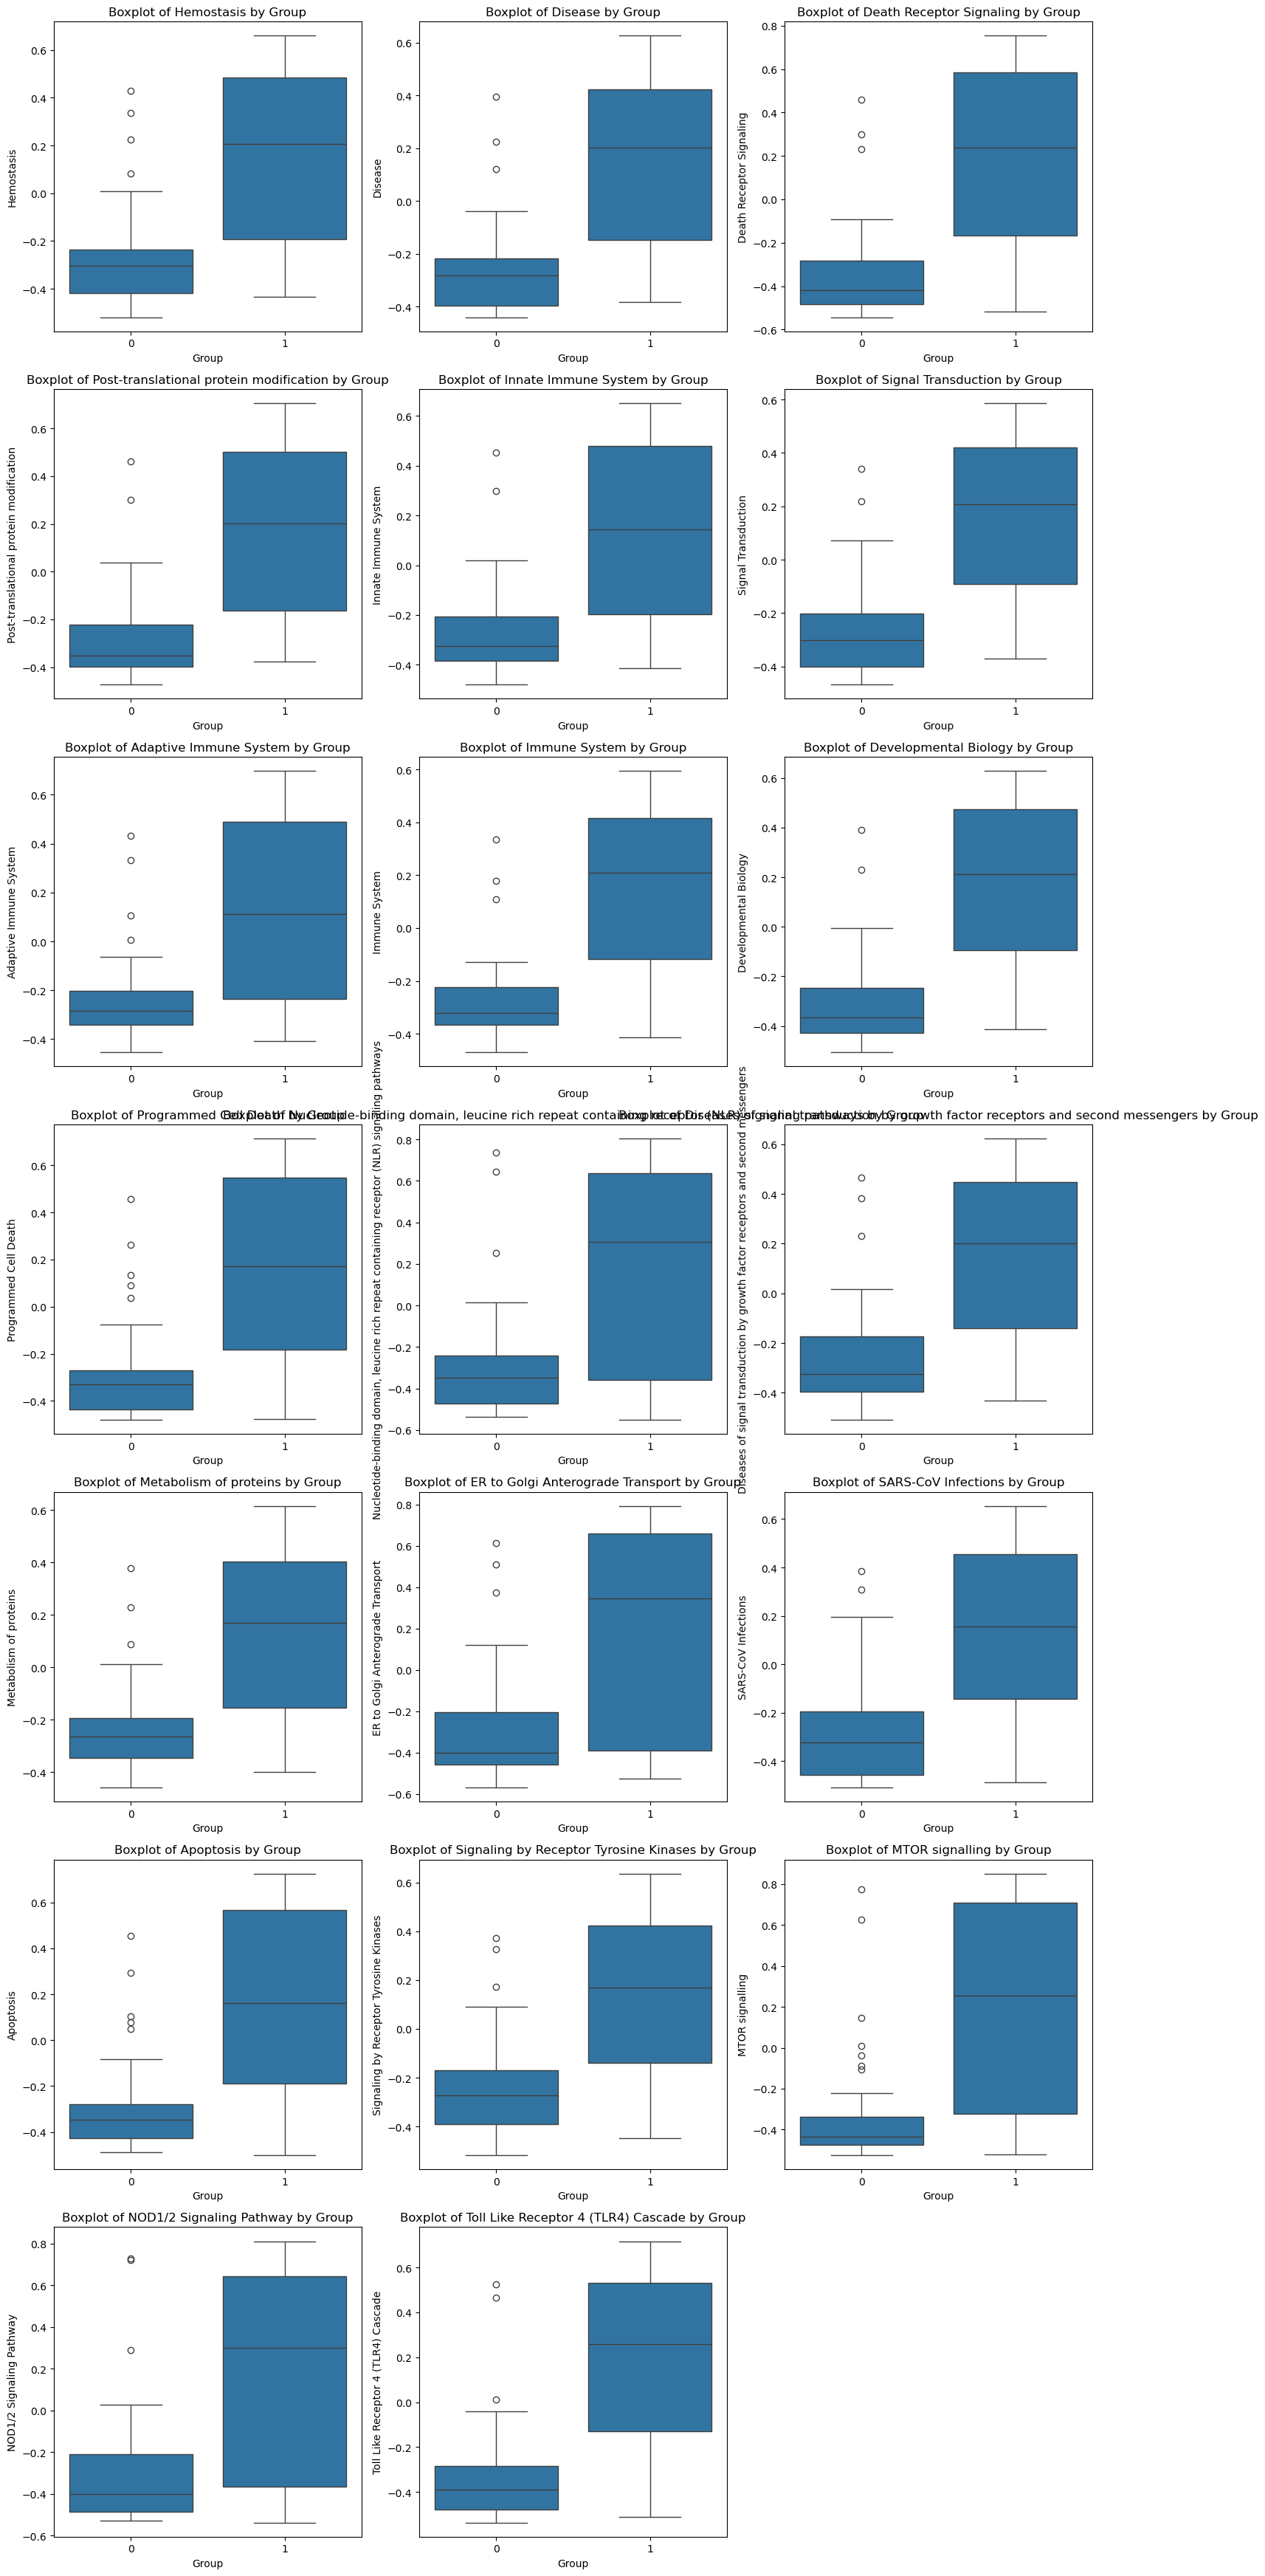

In [141]:
n_plots = len(parafac2_all_prot_sigpath_dict)
n_cols = 3  # Specify the number of columns
n_rows = (n_plots // n_cols) + (n_plots % n_cols > 0)  # Calculate the number of rows needed

# Create a figure and subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

for i, (pathid, pathname) in enumerate(parafac2_all_prot_sigpath_dict.items()):
    # Create the DataFrame correctly
    data = pd.DataFrame({
        'Group': metadata_binary,
        pathname: prot_kpca.loc[:, pathid]  # No curly braces needed here
    })
    
    # Create the boxplot in the respective subplot
    sns.boxplot(x='Group', y=pathname, data=data, ax=axes[i])
    axes[i].set_title(f'Boxplot of {pathname} by Group')  # Dynamic title
    axes[i].set_xlabel('Group')
    axes[i].set_ylabel(pathname)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better readability
plt.tight_layout()
plt.show()

In [120]:
with open('mw_metab.pkl','rb') as f:
    mw_metab = pickle.load(f)
with open('mw_prot.pkl','rb') as f:
    mw_prot = pickle.load(f)

In [142]:
mw_metab.loc[parafac2_all_metab_sigpath_dict.keys()]

p_val
R-HSA-8939211  1.501138e-02
R-HSA-9009391  1.501138e-02
R-HSA-9006931  1.501138e-02
R-HSA-194138   3.332979e-02
R-HSA-4420097  3.332979e-02
R-HSA-9006934  5.431834e-01
R-HSA-71387    2.995133e-79
R-HSA-1614635  1.323930e-42
R-HSA-428157   4.443118e-08
R-HSA-1660661  1.149001e-06
R-HSA-162582   3.458714e-50
R-HSA-83936    2.279349e-22
R-HSA-211945   1.932176e-44
R-HSA-5619102  9.235468e-63
R-HSA-2408522  9.235468e-63
R-HSA-425393   8.954674e-77

In [143]:
mw_prot.loc[parafac2_all_prot_sigpath_dict.keys()]

p_val
R-HSA-109582   3.493703e-52
R-HSA-1643685  1.163892e-35
R-HSA-73887    2.353523e-29
R-HSA-597592   2.453380e-37
R-HSA-168249   2.353523e-29
R-HSA-162582   5.036970e-34
R-HSA-1280218  4.816626e-25
R-HSA-168256   2.572099e-46
R-HSA-1266738  7.162402e-31
R-HSA-5357801  2.279349e-22
R-HSA-168643   1.163892e-35
R-HSA-5663202  1.323930e-42
R-HSA-392499   1.929939e-26
R-HSA-199977   4.816626e-25
R-HSA-9679506  1.703228e-17
R-HSA-109581   2.279349e-22
R-HSA-9006934  4.717529e-39
R-HSA-165159   2.846884e-67
R-HSA-168638   1.932176e-44
R-HSA-166016   1.096878e-23

In [174]:
with open('parafac2_all_prot_sigpath_dict.pkl', 'wb') as f:
    pickle.dump(parafac2_all_prot_sigpath_dict, f)
    
with open('parafac2_all_metab_sigpath_dict.pkl', 'wb') as f:
    pickle.dump(parafac2_all_metab_sigpath_dict, f)

- third method: combined p values

In [ ]:
metab_facs_bs = {0: metab_fac1_bs, 1: metab_fac2_bs}
prot_facs_bs = {0: prot_fac1_bs, 1: prot_fac2_bs}
metab_empirical_test = harmonic_pvalue(metab_facs_bs)

In [ ]:
count_significant = (metab_empirical_test['Harmonic'] < 0.05).sum()

print(f"Number of metabolomics pathways with combined p-value < 0.05: {count_significant}")

Number of metabolomics pathways with combined p-value < 0.05: 98


In [ ]:
prot_empirical_test = harmonic_pvalue(prot_facs_bs)

count_significant = (prot_empirical_test['Harmonic'] < 0.05).sum()
print(f"Number of proteomics pathways with combined p-value < 0.05: {count_significant}")

Number of proteomics pathways with combined p-value < 0.05: 385


In [ ]:
p2all_metab_sigpath = list(metab_empirical_test.index[metab_empirical_test['Harmonic'] < 0.05])
p2all_prot_sigpath = list(prot_empirical_test.index[prot_empirical_test['Harmonic'] < 0.05])

with open('p2all_metab_sigpath.pkl', 'wb') as f:
    pickle.dump(p2all_metab_sigpath, f)

with open('p2all_prot_sigpath.pkl', 'wb') as f:
    pickle.dump(p2all_prot_sigpath, f)

Investigating significant pathways